<a href="https://colab.research.google.com/github/fxrdhan/Machine-Learning-Project/blob/main/Kelompok1_OccupancyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Occupancy Detection Classification menggunakan K-Nearest Neighbors dan Naive Bayes**


**Kelompok:** 1

| **NIM** | **Nama Anggota** |
|---|---|
| 101032300131 | Firdaus Arif Ramadhani |
| 101032300150 | Muhammad Fakhri Arrasyid |
| 101032300119 | Yoga Reswara |

## Deskripsi Project

Project ini bertujuan untuk mengklasifikasikan status okupansi ruangan (occupied/not occupied) berdasarkan data sensor lingkungan menggunakan algoritma **K-Nearest Neighbors (KNN)** dan **Naive Bayes**.

**Dataset:** UCI Occupancy Detection Dataset (Candanedo & Feldheim, 2016)
- 20,560 sampel
- 5 fitur: Temperature, Humidity, Light, CO2, Humidity Ratio
- Target: Binary Classification (0 = Not Occupied, 1 = Occupied)

**Referensi Utama:**
- Candanedo, L.M. & Feldheim, V. (2016). *Energy and Buildings*, 112, 28-39.
- Alam, M.S. et al. (2023). *MDPI Engineering Proceedings*, 58(1), 67.

## Ruang Lingkup Analisis

Penelitian ini memiliki 4 fokus analisis:

1. **Analisis Variasi Nilai k pada KNN** - Menguji pengaruh nilai k (1, 3, 5, 7, ..., 21) terhadap performa model
2. **Perbandingan Varian Naive Bayes** - Membandingkan Gaussian NB vs Bernoulli NB
3. **Feature Importance Analysis** - Mengidentifikasi sensor mana yang paling berpengaruh terhadap prediksi
4. **Trade-off Akurasi vs Waktu Komputasi** - Membandingkan efisiensi kedua algoritma

# **1. Setup dan Installation**

## 1.1. Install library (ucimlrepo)

In [795]:
!pip install ucimlrepo -q

## 1.2. Import semua library

In [796]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance

# Machine Learning - Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve
)

# Utilities
import time
import warnings

# Dataset
from ucimlrepo import fetch_ucirepo

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.2.2
NumPy version: 2.0.2


## 1.3. Settings (random seed, display options, ignore warnings)

In [797]:
# Random seed untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Ignore warnings
warnings.filterwarnings('ignore')

# Dictionary untuk menyimpan semua hasil eksperimen
results = {
    'baseline': {},
    'knn_tuning': {},
    'nb_tuning': {},
    'feature_importance': {},
    'cross_validation': {},
    'time_analysis': {}
}

print(f"Random State: {RANDOM_STATE}")

Random State: 42


# **2. Data Loading**

## **2.1. Info Dataset**

Unduh dataset Occupancy Detection dari UCI Machine Learning Repository menggunakan library `ucimlrepo`.

**Dataset Info:**
- ID: 357
- Nama: Occupancy Detection
- Sumber: Candanedo & Feldheim (2016)
- Link: https://archive.ics.uci.edu/dataset/357/occupancy+detection

## 2.2 Download UCI Dataset

In [798]:
occupancy_detection = fetch_ucirepo(id=357)

## 2.3. Metadata Dataset

In [799]:
# Ambil metadata
metadata = occupancy_detection.metadata
variables = occupancy_detection.variables

print(f"\nNama Dataset: {getattr(metadata, 'name', 'N/A')}")
print(f"UCI ID: {getattr(metadata, 'uci_id', 'N/A')}")

print(f"\n--- Informasi Umum ---")
print(f"Jumlah Instances: {getattr(metadata, 'num_instances', 'N/A')}")
print(f"Jumlah Features: {getattr(metadata, 'num_features', 'N/A')}")

print(f"\n--- Tipe Task ---")
print(f"Task: {getattr(metadata, 'task', 'N/A')}")
print(f"Area: {getattr(metadata, 'area', 'N/A')}")

print(f"\n--- Variabel ---")
for idx, row in variables.iterrows():
    print(f"  - {row['name']}: {row['type']} ({row['role']})")


Nama Dataset: Occupancy Detection 
UCI ID: 357

--- Informasi Umum ---
Jumlah Instances: 20560
Jumlah Features: 6

--- Tipe Task ---
Task: None
Area: Computer Science

--- Variabel ---
  - id: Integer (ID)
  - date: Date (Feature)
  - Temperature: Integer (Feature)
  - Humidity: Continuous (Feature)
  - Light: Integer (Feature)
  - CO2: Continuous (Feature)
  - HumidityRatio: Continuous (Feature)
  - Occupancy: Binary (Target)


## 2.4. Buat DataFrame

In [800]:
# Ambil features dan target
X = occupancy_detection.data.features
y = occupancy_detection.data.targets

# Gabung menjadi satu DataFrame untuk EDA
df = pd.concat([X, y], axis=1)

# Tampilkan nama kolom
print("Kolom Features (X):")
print(list(X.columns))

print("\nKolom Target (y):")
print(list(y.columns))

print("\nKolom DataFrame Gabungan:")
print(list(df.columns))

Kolom Features (X):
['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

Kolom Target (y):
['Occupancy']

Kolom DataFrame Gabungan:
['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']


## 2.5. Cek Shape dan Info Dasar


In [801]:
print(f"\n--- Shape ---")
print(f"Features (X): {X.shape} -> {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target (y): {y.shape} -> {y.shape[0]} samples")
print(f"DataFrame: {df.shape}")

print(f"\n--- Memory Usage ---")
print(f"Features: {X.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Target: {y.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Total: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

print(f"\n--- Preview Data (5 baris pertama) ---")
df.head()


--- Shape ---
Features (X): (20562, 6) -> 20562 samples, 6 features
Target (y): (20562, 1) -> 20562 samples
DataFrame: (20562, 7)

--- Memory Usage ---
Features: 7046.29 KB
Target: 160.77 KB
Total: 7206.93 KB

--- Preview Data (5 baris pertama) ---


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529,1.0000
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065,1.0000
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199,1.0000
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175,1.0000
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518,1.0000


# **3. Exploratory Data Analysis (EDA)**

## 3.1. Overview


Lihat struktur dan karakteristik dasar dari dataset.

### 3.1.1. n Baris Pertama dan Terakhir DataFrame

In [802]:
display(df.head())

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529,1.0000
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065,1.0000
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199,1.0000
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175,1.0000
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518,1.0000


In [803]:
display(df.tail())

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
20557,2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.00421296819328694,1.0000
20558,2015-02-18 09:16:00,20.865,27.745,423.5,1514.5,0.00423026193160229,1.0000
20559,2015-02-18 09:16:59,20.89,27.745,423.5,1521.5,0.00423681810140671,1.0000
20560,2015-02-18 09:17:59,20.89,28.0225,418.75,1632,0.0042794854718673,1.0000
20561,2015-02-18 09:19:00,21,28.1,409,1864,0.00432073200293677,1.0000


### 3.1.2. Info DataFrame

In [804]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20562 entries, 0 to 20561
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20562 non-null  object 
 1   Temperature    20562 non-null  object 
 2   Humidity       20562 non-null  object 
 3   Light          20562 non-null  object 
 4   CO2            20562 non-null  object 
 5   HumidityRatio  20562 non-null  object 
 6   Occupancy      20560 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.1+ MB


### 3.1.3. Fix Data Types

In [805]:
print(df.dtypes)

date              object
Temperature       object
Humidity          object
Light             object
CO2               object
HumidityRatio     object
Occupancy        float64
dtype: object


In [806]:
# Konversi kolom numerik ke numeric
numeric_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Konversi Occupancy ke numeric (biarkan float dulu)
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')

In [807]:
# Missing values setelah konversi
print(f"\nMissing values setelah konversi:")
print(df.isnull().sum())



Missing values setelah konversi:
date             0
Temperature      2
Humidity         2
Light            2
CO2              2
HumidityRatio    2
Occupancy        2
dtype: int64


In [808]:
# Drop rows dengan NaN (jika ada)
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"\nRows sebelum dropna: {rows_before}")
print(f"Rows sesudah dropna: {rows_after}")
print(f"Rows dihapus: {rows_before - rows_after}")


Rows sebelum dropna: 20562
Rows sesudah dropna: 20560
Rows dihapus: 2


In [809]:
# Convert Occupancy ke int
df['Occupancy'] = df['Occupancy'].astype(int)

In [810]:
print(df.dtypes)

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object


### 3.1.4. Statistik Deskriptif

In [811]:
# Hanya untuk kolom numerik (exclude date)
numeric_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
df[numeric_cols + ['Occupancy']].describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.0000,20560.0000,20560.0000,20560.0000,20560.0000,20560.0000
mean,20.9062,27.6559,130.7566,690.5533,0.0042,0.2310
std,1.0553,4.9822,210.4309,311.2013,0.0008,0.4215
min,19.0000,16.7450,0.0000,412.7500,0.0027,0.0000
25%,20.2000,24.5000,0.0000,460.0000,0.0037,0.0000
50%,20.7000,27.2900,0.0000,565.4167,0.0043,0.0000
75%,21.5250,31.2900,301.0000,804.6667,0.0048,0.0000
max,24.4083,39.5000,1697.2500,2076.5000,0.0065,1.0000


## 3.2. Target Analysis

Menganalisis distribusi kelas target (Occupancy) untuk memahami proporsi data occupied vs not occupied.

### 3.2.1. Value Counts Target

In [812]:
target_counts = df['Occupancy'].value_counts()
target_pct = df['Occupancy'].value_counts(normalize=True) * 100

target_dist = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_pct.round(2)
})
target_dist.index = ['Not Occupied (0)', 'Occupied (1)']

print(target_dist)

                  Count  Percentage (%)
Not Occupied (0)  15810         76.9000
Occupied (1)       4750         23.1000


### 3.2.2. Visualisasi Distribusi Target

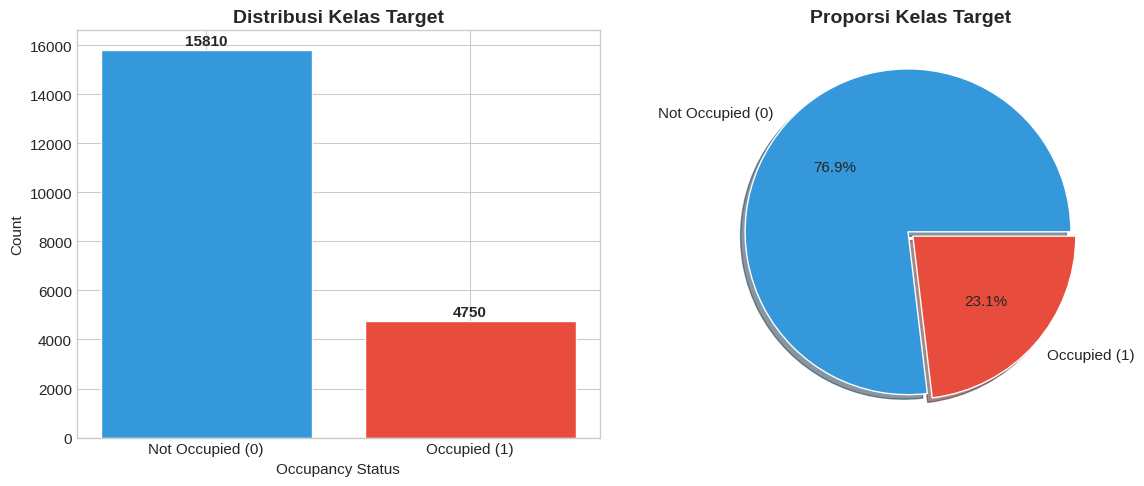

In [813]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar Chart
colors = ['#3498db', '#e74c3c']
target_counts = df['Occupancy'].value_counts()

axes[0].bar(['Not Occupied (0)', 'Occupied (1)'], target_counts.values, color=colors)
axes[0].set_title('Distribusi Kelas Target', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Occupancy Status')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# Pie Chart
axes[1].pie(target_counts.values,
            labels=['Not Occupied (0)', 'Occupied (1)'],
            autopct='%1.1f%%',
            colors=colors,
            explode=(0.02, 0.02),
            shadow=True)
axes[1].set_title('Proporsi Kelas Target', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.2.3. Class Imbalance Ratio

In [814]:
count_0 = (df['Occupancy'] == 0).sum()
count_1 = (df['Occupancy'] == 1).sum()

imbalance_ratio = count_0 / count_1

print(f"Not Occupied (0): {count_0}")
print(f"Occupied (1): {count_1}")
print(f"\nImbalance Ratio (0:1): {imbalance_ratio:.2f} : 1")

if imbalance_ratio > 1.5:
    print(f"\nStatus: Dataset IMBALANCED")
    print(f"Kelas mayoritas (Not Occupied) {imbalance_ratio:.2f}x lebih banyak dari kelas minoritas")
    print("Rekomendasi: Gunakan Stratified Split untuk menjaga proporsi kelas")
else:
    print(f"\nStatus: Dataset BALANCED")

Not Occupied (0): 15810
Occupied (1): 4750

Imbalance Ratio (0:1): 3.33 : 1

Status: Dataset IMBALANCED
Kelas mayoritas (Not Occupied) 3.33x lebih banyak dari kelas minoritas
Rekomendasi: Gunakan Stratified Split untuk menjaga proporsi kelas


## 3.3 Feature Distribution

Menganalisis distribusi setiap fitur untuk memahami karakteristik data dan mendeteksi outliers.

**Fitur yang dianalisis:**
1. Temperature (suhu ruangan)
2. Humidity (kelembaban relatif)
3. Light (intensitas cahaya)
4. CO2 (konsentrasi karbondioksida)
5. HumidityRatio (rasio kelembaban)

### 3.3.1. Histogram Semua Fitur

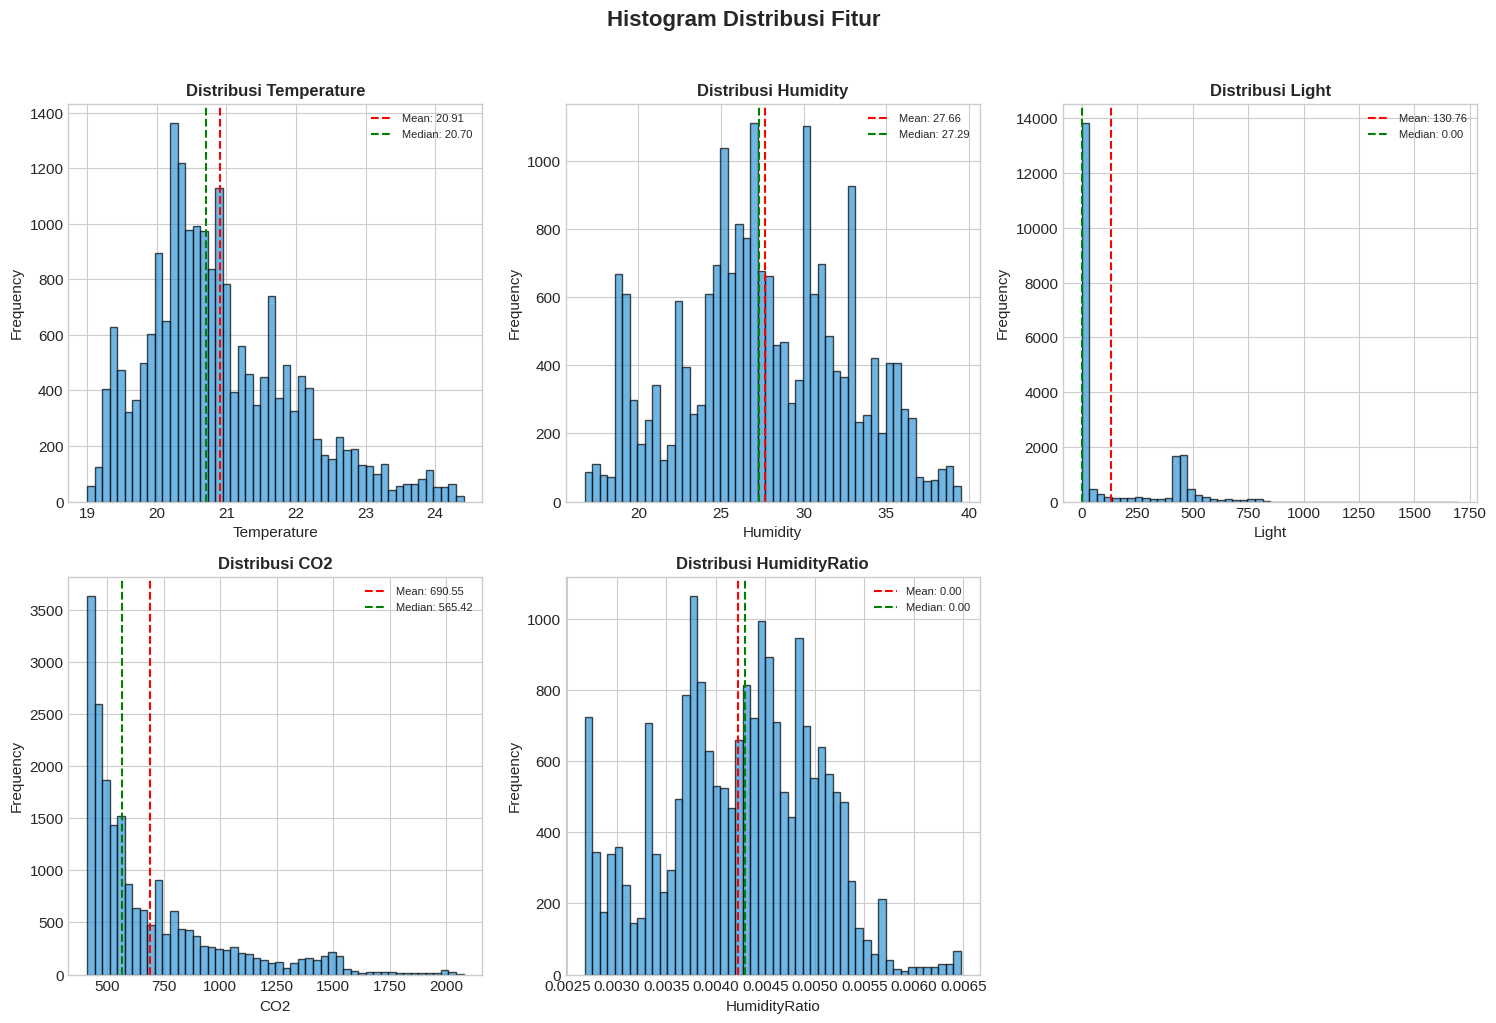

In [815]:
numeric_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribusi {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    axes[idx].axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.2f}')
    axes[idx].legend(fontsize=8)

# Hapus subplot kosong (index 5)
axes[5].axis('off')

plt.suptitle('Histogram Distribusi Fitur', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3.2. Boxplot Semua Fitur

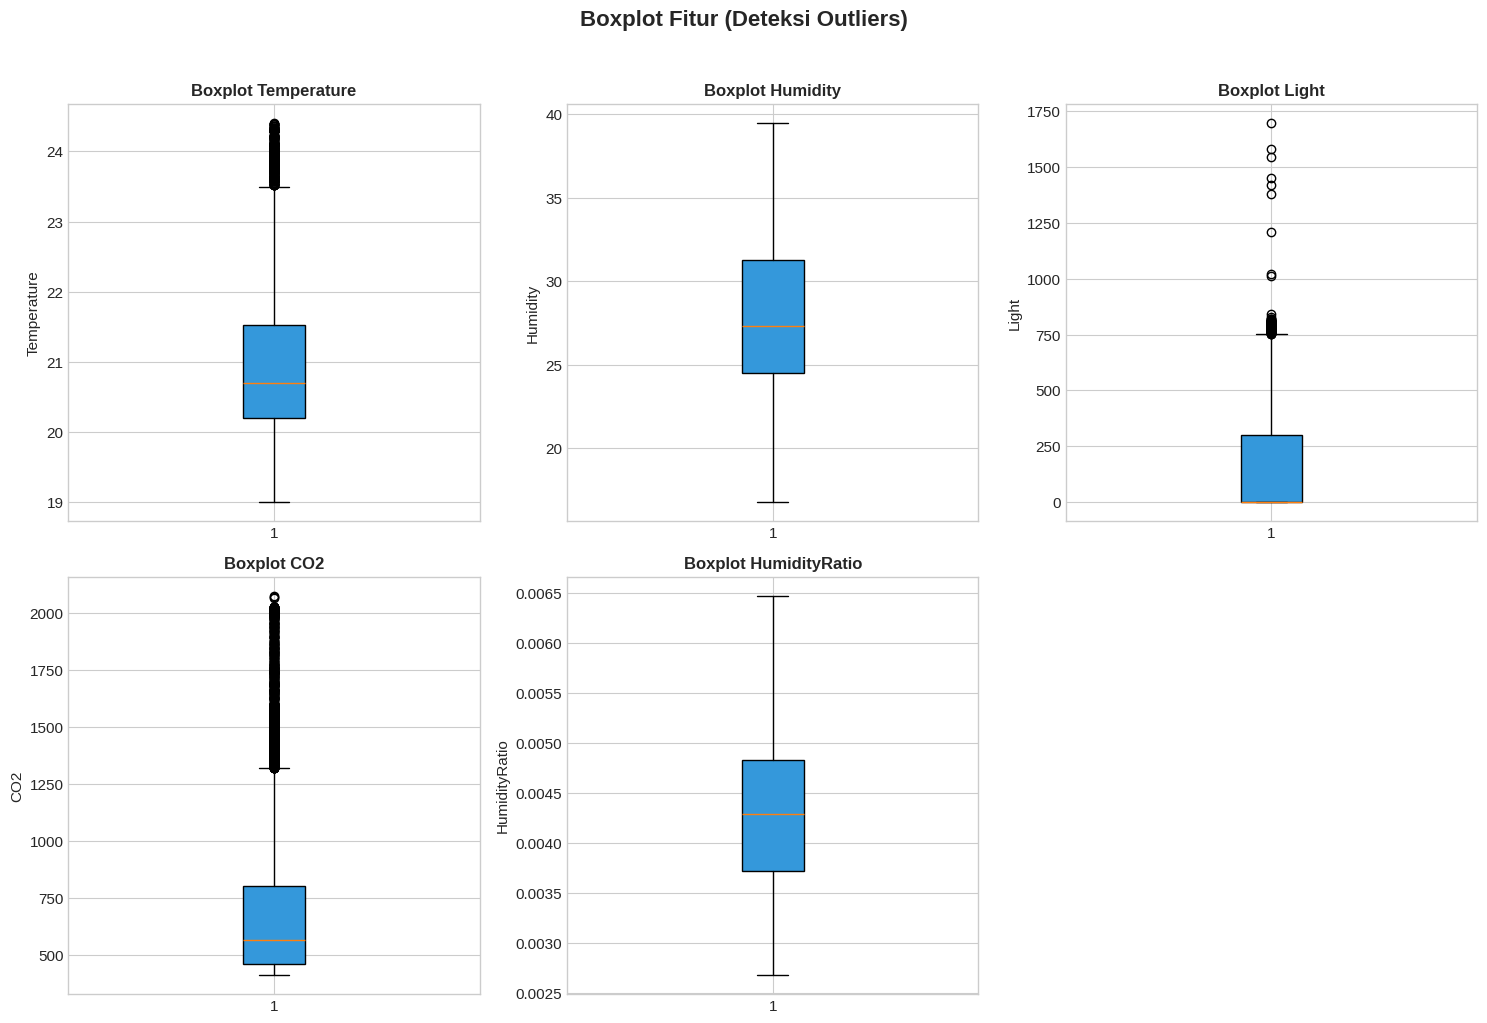

In [816]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    bp = axes[idx].boxplot(df[col], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    axes[idx].set_title(f'Boxplot {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)

# Hapus subplot kosong
axes[5].axis('off')

plt.suptitle('Boxplot Fitur (Deteksi Outliers)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3.3. Deteksi Outliers dengan IQR Method

In [817]:
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df) * 100)

    outlier_summary.append({
        'Feature': col,
        'Q1': round(Q1, 4),
        'Q3': round(Q3, 4),
        'IQR': round(IQR, 4),
        'Lower Bound': round(lower_bound, 4),
        'Upper Bound': round(upper_bound, 4),
        'Outlier Count': outlier_count,
        'Outlier %': round(outlier_pct, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

,Feature,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier %
0,Temperature,20.2000,21.5250,1.3250,18.2125,23.5125,519,2.5200
1,Humidity,24.5000,31.2900,6.7900,14.3150,41.4750,0,0.0000
2,Light,0.0000,301.0000,301.0000,-451.5000,752.5000,183,0.8900
3,CO2,460.0000,804.6667,344.6667,-57.0000,1321.6667,1449,7.0500
4,HumidityRatio,0.0037,0.0048,0.0011,0.0020,0.0065,0,0.0000


Catatan: Outliers TIDAK akan dihapus karena merepresentasikan kondisi nyata

(contoh: Light=0 saat malam hari, CO2 tinggi saat banyak orang)

## 3.4 Correlation Analysis

Menganalisis korelasi antar fitur dan korelasi fitur dengan target untuk mengidentifikasi fitur yang paling berpengaruh.

### 3.4.1. Correlation Matrix

In [818]:
# Buat correlation matrix (hanya numerik)
corr_cols = numeric_cols + ['Occupancy']
corr_matrix = df[corr_cols].corr()

print(corr_matrix.round(4))

               Temperature  Humidity   Light    CO2  HumidityRatio  Occupancy
Temperature         1.0000   -0.1570  0.6886 0.4500         0.2053     0.5556
Humidity           -0.1570    1.0000 -0.0295 0.2997         0.9327     0.0462
Light               0.6886   -0.0295  1.0000 0.4481         0.2233     0.9148
CO2                 0.4500    0.2997  0.4481 1.0000         0.4780     0.5016
HumidityRatio       0.2053    0.9327  0.2233 0.4780         1.0000     0.2573
Occupancy           0.5556    0.0462  0.9148 0.5016         0.2573     1.0000


### 3.4.2. Heatmap Correlation

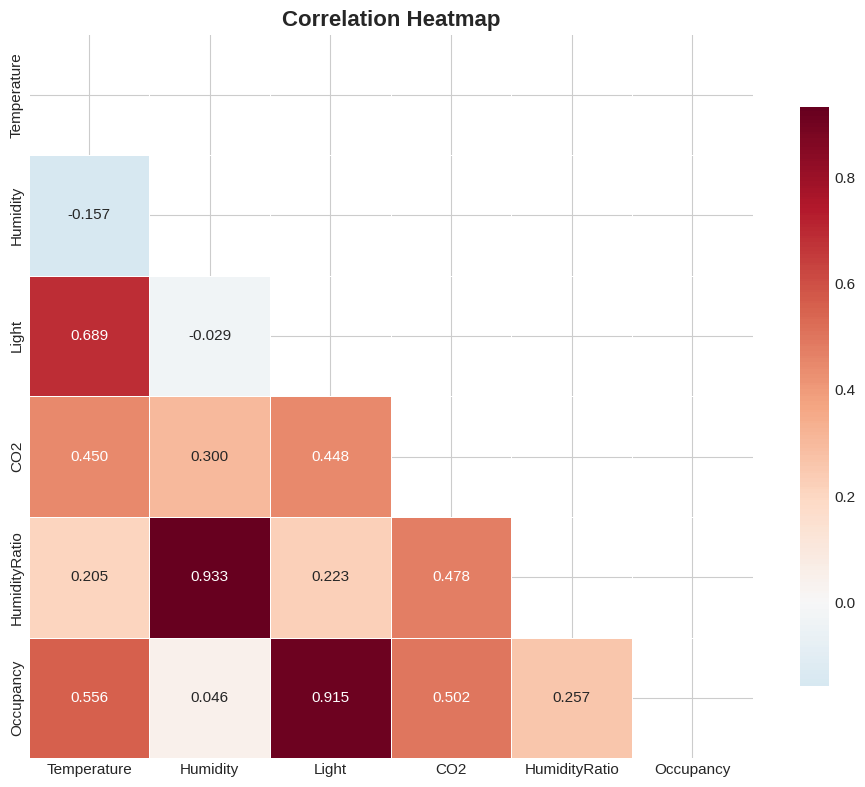

In [819]:
plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            center=0,
            mask=mask,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4.4. Korelasi Fitur dengan Target

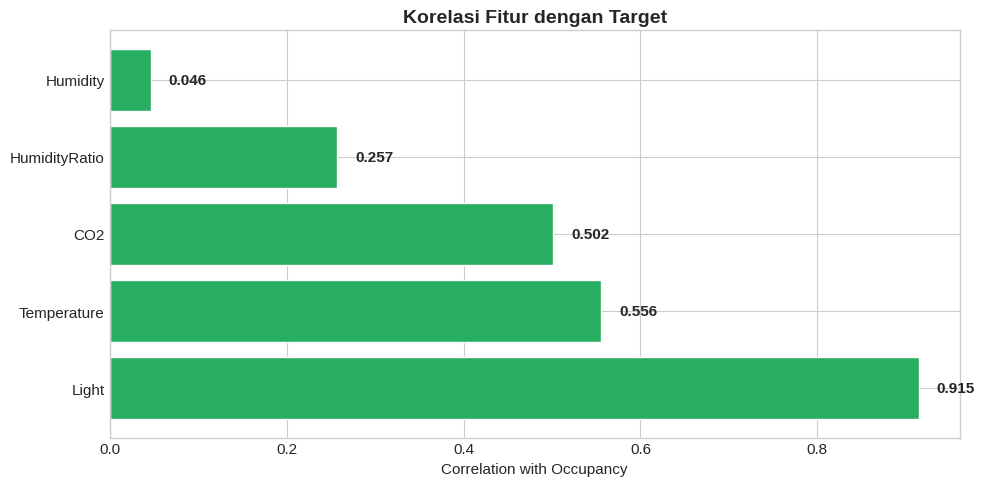


--- INSIGHT ---


In [820]:
# Hitung korelasi dengan target
corr_with_target = df[numeric_cols].corrwith(df['Occupancy']).sort_values(ascending=False)

corr_target_df = pd.DataFrame({
    'Feature': corr_with_target.index,
    'Correlation': corr_with_target.values,
    'Abs Correlation': abs(corr_with_target.values)
}).sort_values('Abs Correlation', ascending=False)

# Visualisasi
plt.figure(figsize=(10, 5))
colors = ['#27ae60' if x > 0 else '#e74c3c' for x in corr_with_target.values]
bars = plt.barh(corr_with_target.index, corr_with_target.values, color=colors)
plt.xlabel('Correlation with Occupancy')
plt.title('Korelasi Fitur dengan Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)

# Tambah label nilai
for bar, val in zip(bars, corr_with_target.values):
    plt.text(val + 0.02 if val > 0 else val - 0.08, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Insight
print("\n--- INSIGHT ---")
top_feature = corr_target_df.iloc[0]['Feature']
top_corr = corr_target_df.iloc[0]['Correlation']

### 3.4.4. Pairplot

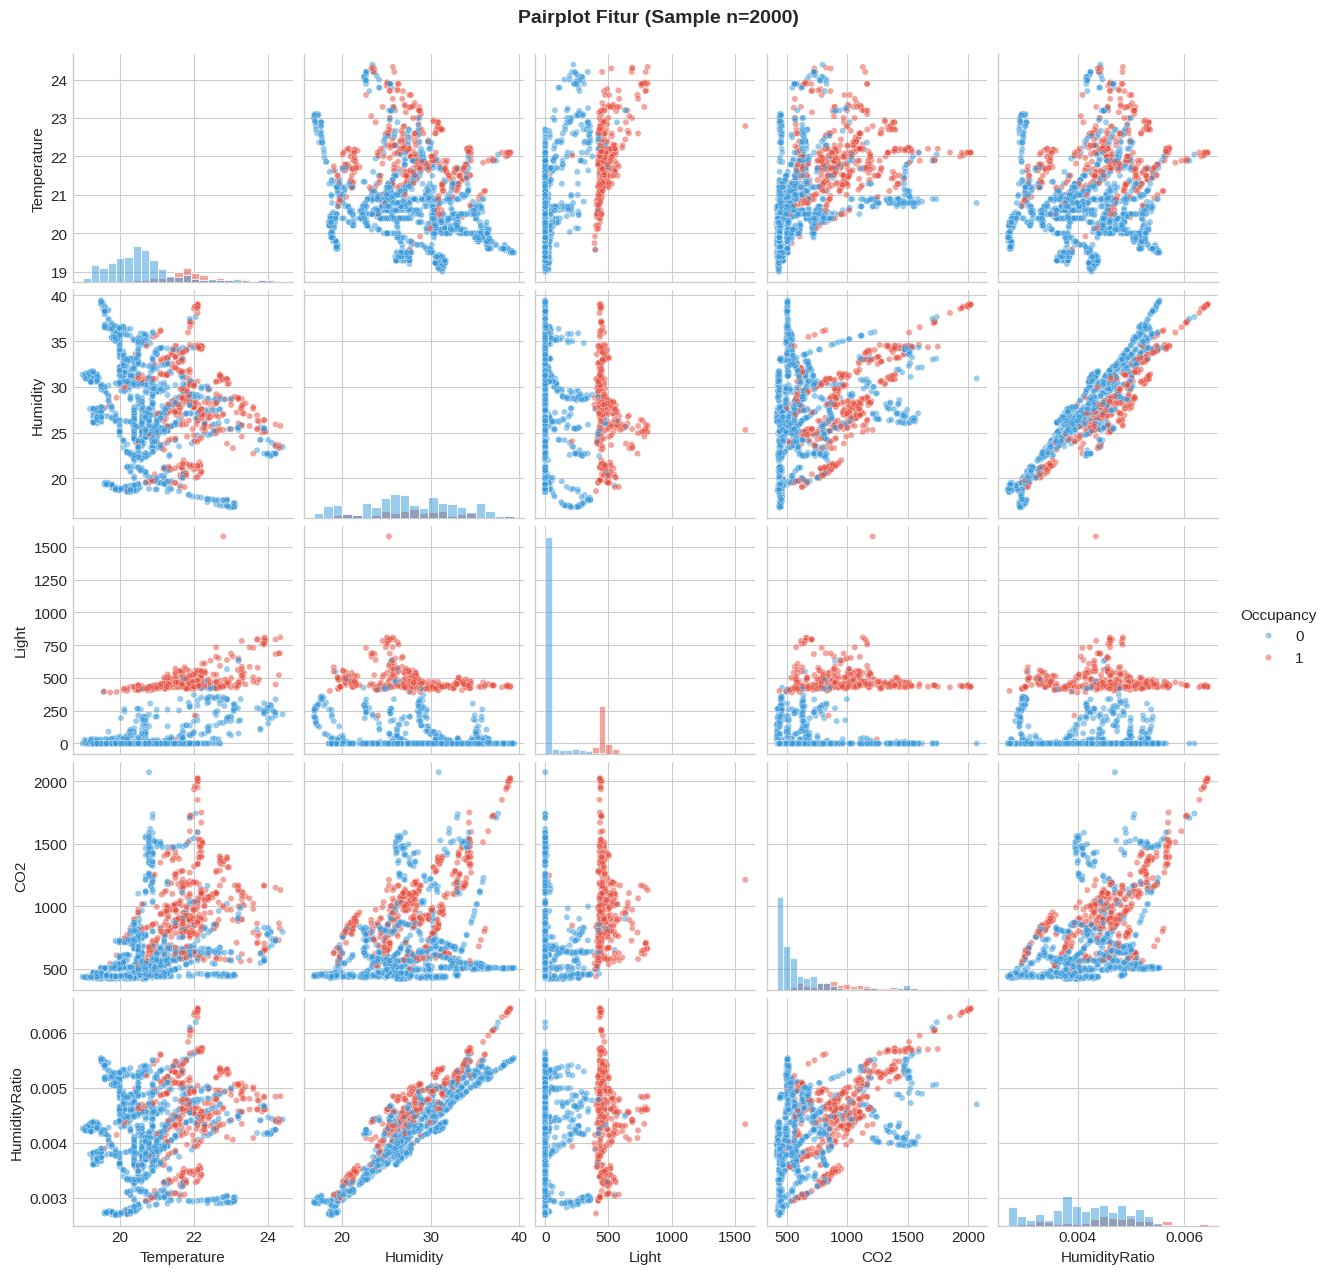

In [821]:
# Sample data untuk pairplot agar tidak terlalu lama
df_sample = df[numeric_cols + ['Occupancy']].sample(n=2000, random_state=RANDOM_STATE)

sns.pairplot(df_sample, hue='Occupancy', palette=['#3498db', '#e74c3c'],
             diag_kind='hist', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle('Pairplot Fitur (Sample n=2000)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 3.5. EDA Summary

**1. Data Overview:**
- Total samples: 20,560 (setelah drop 2 rows dengan NaN)
- Total features: 5 fitur numerik (Temperature, Humidity, Light, CO2, HumidityRatio)
- Kolom 'date' tidak digunakan untuk modeling
- Tidak ada missing values setelah preprocessing

**2. Target Distribution:**
- Not Occupied (0): 15,810 (76.9%)
- Occupied (1): 4,750 (23.1%)
- Dataset IMBALANCED dengan rasio 3.33 : 1
- Perlu menggunakan Stratified Split untuk menjaga proporsi

**3. Feature Distribution:**
- Light: Sangat skewed, banyak nilai 0 (lampu mati/malam hari), Mean=130.76, Median=0
- CO2: Skewed dengan outliers 7.05% (1,449 data), Mean=690.55, Median=565.42
- Temperature: Relatif normal, outliers 2.52% (519 data)
- Humidity: Normal, tidak ada outliers
- HumidityRatio: Normal, tidak ada outliers
- Outliers TIDAK dihapus karena merepresentasikan kondisi nyata

**4. Correlation dengan Target (Occupancy):**

| Fitur | Korelasi | Interpretasi |
|-------|----------|--------------|
| Light | 0.915 | Sangat Kuat (Positif) |
| Temperature | 0.556 | Sedang (Positif) |
| CO2 | 0.502 | Sedang (Positif) |
| HumidityRatio | 0.257 | Lemah (Positif) |
| Humidity | 0.046 | Sangat Lemah |

**5. Insight Utama:**
- **Light adalah fitur paling penting** dengan korelasi 0.915 (sesuai paper asli)
- Temperature dan CO2 juga cukup diskriminatif
- Humidity hampir tidak berpengaruh terhadap occupancy

# **4. Data Preprocessing**

Pada section ini kita akan:
1. Memisahkan features (X) dan target (y)
2. Split data menjadi training dan test set (80:20)
3. Melakukan feature scaling dengan RobustScaler

**Catatan:** Kolom 'date' tidak digunakan untuk modeling.

## 4.1. Pisahkan Features (X) dan Target (y)

In [822]:
# Fitur yang akan digunakan (exclude 'date')
feature_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [823]:
X = df[feature_cols].copy()
y = df['Occupancy'].copy()

In [824]:
print(f"Features: {feature_cols}")
print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")

Features: ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

Shape X: (20560, 5)
Shape y: (20560,)


In [825]:
display(X.head())

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.1800,27.2720,426.0000,721.2500,0.0048
1,23.1500,27.2675,429.5000,714.0000,0.0048
2,23.1500,27.2450,426.0000,713.5000,0.0048
3,23.1500,27.2000,426.0000,708.2500,0.0048
4,23.1000,27.2000,426.0000,704.5000,0.0048


In [826]:
display(y.head())

,Occupancy
0,1
1,1
2,1
3,1
4,1


## 4.2. Train-Test Split (Stratified)

In [827]:
# Split dengan stratify untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # Penting: menjaga proporsi kelas
)

In [828]:
print(f"Test Size: 20%")
print(f"Random State: {RANDOM_STATE}")
print(f"Stratified: Yes")

Test Size: 20%
Random State: 42
Stratified: Yes


In [829]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (16448, 5)
X_test: (4112, 5)
y_train: (16448,)
y_test: (4112,)


In [830]:
print(f"Total Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Total Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Total Training: 16448 (80.0%)
Total Test: 4112 (20.0%)


## 4.3. Cek Proporsi Kelas Setelah Split

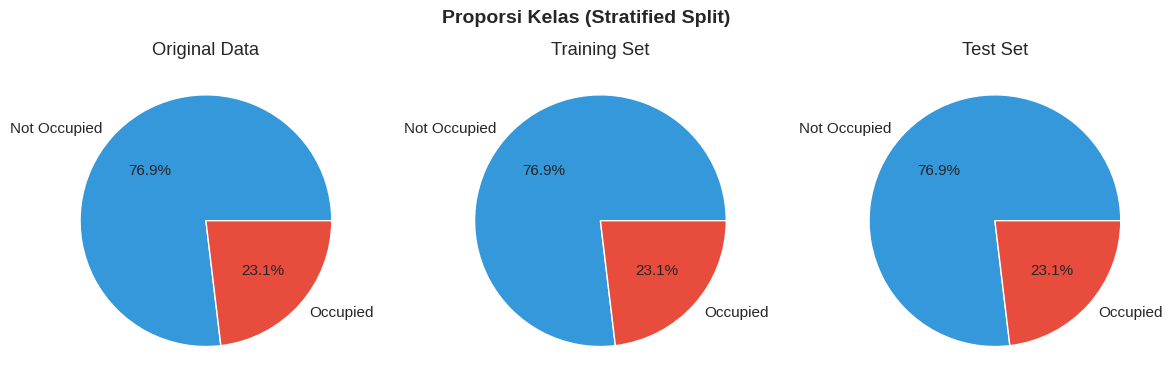

In [831]:
# Proporsi di training set
train_counts = y_train.value_counts()
train_pct = y_train.value_counts(normalize=True) * 100

# Proporsi di test set
test_counts = y_test.value_counts()
test_pct = y_test.value_counts(normalize=True) * 100

# Proporsi original
orig_pct = y.value_counts(normalize=True) * 100

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].pie(y.value_counts().values, labels=['Not Occupied', 'Occupied'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[0].set_title('Original Data')

axes[1].pie(y_train.value_counts().values, labels=['Not Occupied', 'Occupied'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[1].set_title('Training Set')

axes[2].pie(y_test.value_counts().values, labels=['Not Occupied', 'Occupied'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[2].set_title('Test Set')

plt.suptitle('Proporsi Kelas (Stratified Split)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.4. Feature Scaling (RobustScaler)

**Formula:**
$$z = \frac{x - Q_2}{Q_3 - Q_1}$$

where:
- $x$ = original value
- $Q_2$ = median of the training data
- $Q_1$ = first quartile (25th percentile)
- $Q_3$ = third quartile (75th percentile)
- $Q_3 - Q_1$ = Interquartile Range (IQR)
- $z$ = scaled value

In [832]:
# Menggunakan RobustScaler karena data mengandung outliers
scaler = RobustScaler()

# Fit on training data, transform on training and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [833]:
# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

In [834]:
print(f"Shape X_train_scaled: {X_train_scaled.shape}")
print(f"Shape X_test_scaled: {X_test_scaled.shape}")

Shape X_train_scaled: (16448, 5)
Shape X_test_scaled: (4112, 5)


## 4.5. Cek Hasil Scaling

In [835]:
# Buat DataFrame perbandingan
comparison_data = []

for col in feature_cols:
    comparison_data.append({
        'Feature': col,
        'Before Mean': X_train[col].mean(),
        'Before Std': X_train[col].std(),
        'Before Min': X_train[col].min(),
        'Before Max': X_train[col].max(),
        'After Mean': X_train_scaled[col].mean(),
        'After Std': X_train_scaled[col].std(),
        'After Min': X_train_scaled[col].min(),
        'After Max': X_train_scaled[col].max()
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df.round(4))

,Feature,Before Mean,Before Std,Before Min,Before Max,After Mean,After Std,After Min,After Max
0,Temperature,20.9042,1.0550,19.0000,24.4083,0.1571,0.8115,-1.3077,2.8526
1,Humidity,27.6550,4.9800,16.7900,39.5000,0.0537,0.7334,-1.5464,1.7982
2,Light,130.6717,210.7280,0.0000,1697.2500,0.4341,0.7001,0.0000,5.6387
3,CO2,691.0197,312.4068,413.0000,2076.5000,0.3643,0.9068,-0.4426,4.3857
4,HumidityRatio,0.0042,0.0008,0.0027,0.0065,-0.0573,0.6933,-1.4582,1.9698


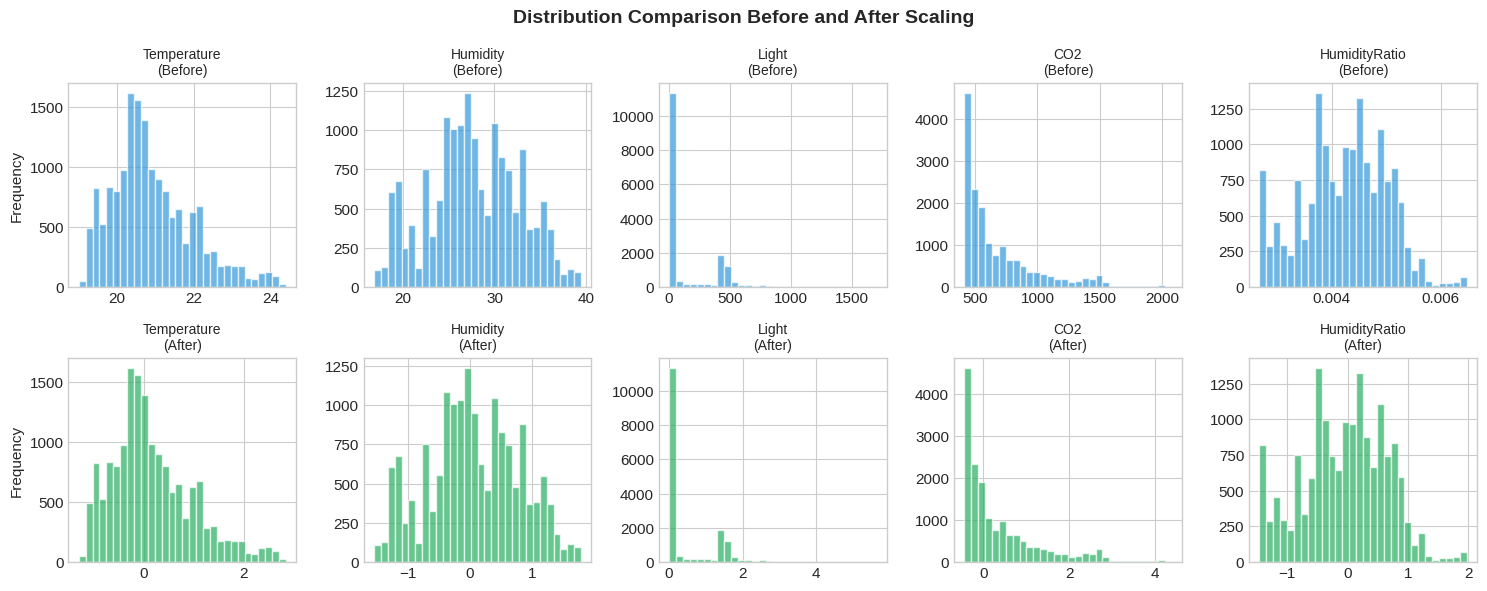

In [836]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, col in enumerate(feature_cols):
    # Sebelum scaling
    axes[0, idx].hist(X_train[col], bins=30, color='#3498db', alpha=0.7)
    axes[0, idx].set_title(f'{col}\n(Before)', fontsize=10)
    axes[0, idx].set_ylabel('Frequency' if idx == 0 else '')

    # Sesudah scaling
    axes[1, idx].hist(X_train_scaled[col], bins=30, color='#27ae60', alpha=0.7)
    axes[1, idx].set_title(f'{col}\n(After)', fontsize=10)
    axes[1, idx].set_ylabel('Frequency' if idx == 0 else '')

plt.suptitle('Distribution Comparison Before and After Scaling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [837]:
print(f"Mean setelah scaling: {X_train_scaled.mean().mean():.6f} (expected: ~0)")
print(f"Std setelah scaling: {X_train_scaled.std().mean():.6f} (expected: ~1)")

Mean setelah scaling: 0.190403 (expected: ~0)
Std setelah scaling: 0.769024 (expected: ~1)


## 4.6. Summary Data Preprocessing

In [838]:
print(f"""
--- Dataset Info ---
Original samples: {len(df)}
Features used: {feature_cols}
Target: Occupancy (Binary: 0/1)

--- Train-Test Split ---
Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)
Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)
Stratified: Yes

--- Feature Scaling ---
Method: RobustdScaler
Fit on: Training data only
Transform on: Training and Test data

--- Variabel yang tersedia ---
X_train_scaled: Training features (scaled)
X_test_scaled: Test features (scaled)
y_train: Training target
y_test: Test target
""")

# Simpan info ke results dictionary
results['preprocessing'] = {
    'n_samples': len(df),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'features': feature_cols,
    'scaler': 'RobustScaler',
    'test_size': 0.2,
    'stratified': True
}


--- Dataset Info ---
Original samples: 20560
Features used: ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
Target: Occupancy (Binary: 0/1)

--- Train-Test Split ---
Training set: 16448 samples (80.0%)
Test set: 4112 samples (20.0%)
Stratified: Yes

--- Feature Scaling ---
Method: RobustdScaler
Fit on: Training data only
Transform on: Training and Test data

--- Variabel yang tersedia ---
X_train_scaled: Training features (scaled)
X_test_scaled: Test features (scaled)
y_train: Training target
y_test: Test target



# **5. Baseline Model**

Buat baseline model untuk:
1. **KNN** dengan k=5 (default)
2. **Gaussian Naive Bayes**

Baseline ini akan menjadi referensi untuk hyperparameter tuning selanjutnya.

### 5.1. KNN Baseline

In [839]:
# Inisialisasi model
knn_baseline = KNeighborsClassifier(n_neighbors=5)

# Training + catat waktu
start_train = time.time()
knn_baseline.fit(X_train_scaled, y_train)
knn_train_time = time.time() - start_train

# Prediksi + catat waktu
start_pred = time.time()
y_pred_knn = knn_baseline.predict(X_test_scaled)
knn_pred_time = time.time() - start_pred

# Hitung metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f"Parameter: k=5 (default)")
print(f"\n--- Waktu Komputasi ---")
print(f"Training Time: {knn_train_time:.4f} detik")
print(f"Prediction Time: {knn_pred_time:.4f} detik")

print(f"\n--- Metrics ---")
print(f"Accuracy:  {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall:    {knn_recall:.4f}")
print(f"F1-Score:  {knn_f1:.4f}")

print(f"\n--- Classification Report ---")
print(classification_report(y_test, y_pred_knn, target_names=['Not Occupied', 'Occupied']))

Parameter: k=5 (default)

--- Waktu Komputasi ---
Training Time: 0.0180 detik
Prediction Time: 0.0450 detik

--- Metrics ---
Accuracy:  0.9925 (99.25%)
Precision: 0.9801
Recall:    0.9874
F1-Score:  0.9837

--- Classification Report ---
              precision    recall  f1-score   support

Not Occupied       1.00      0.99      1.00      3162
    Occupied       0.98      0.99      0.98       950

    accuracy                           0.99      4112
   macro avg       0.99      0.99      0.99      4112
weighted avg       0.99      0.99      0.99      4112



### 5.2. KNN Confusion Matrix

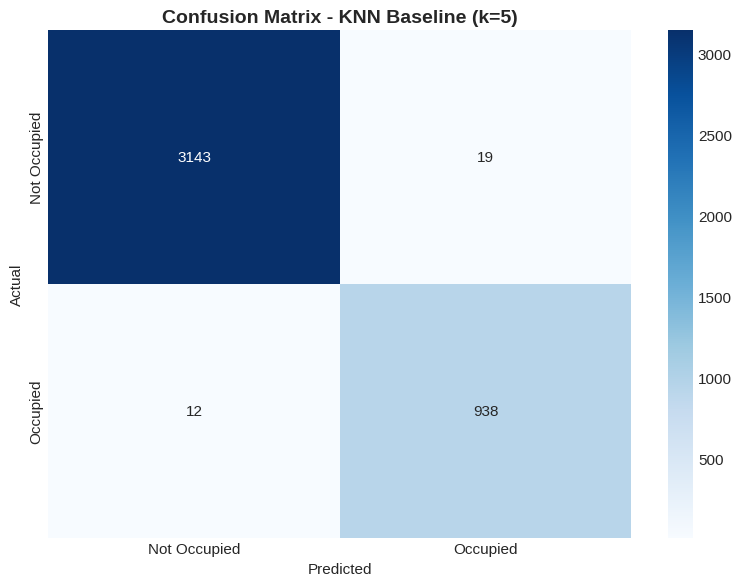

In [840]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Occupied', 'Occupied'],
            yticklabels=['Not Occupied', 'Occupied'])
plt.title('Confusion Matrix - KNN Baseline (k=5)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [841]:
# Detail confusion matrix
tn, fp, fn, tp = cm_knn.ravel()
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

True Negative (TN): 3143
False Positive (FP): 19
False Negative (FN): 12
True Positive (TP): 938


### 5.3. Gaussian Naive Bayes Baseline

In [842]:
# Inisialisasi model
gnb_baseline = GaussianNB()

# Training + catat waktu
start_train = time.time()
gnb_baseline.fit(X_train_scaled, y_train)
gnb_train_time = time.time() - start_train

# Prediksi + catat waktu
start_pred = time.time()
y_pred_gnb = gnb_baseline.predict(X_test_scaled)
gnb_pred_time = time.time() - start_pred

# Hitung metrics
gnb_accuracy = accuracy_score(y_test, y_pred_gnb)
gnb_precision = precision_score(y_test, y_pred_gnb)
gnb_recall = recall_score(y_test, y_pred_gnb)
gnb_f1 = f1_score(y_test, y_pred_gnb)

In [843]:
print(f"Parameter: Default")
print(f"\n--- Waktu Komputasi ---")
print(f"Training Time: {gnb_train_time:.4f} detik")
print(f"Prediction Time: {gnb_pred_time:.4f} detik")

Parameter: Default

--- Waktu Komputasi ---
Training Time: 0.0105 detik
Prediction Time: 0.0032 detik


In [844]:
print(f"Accuracy:  {gnb_accuracy:.4f} ({gnb_accuracy*100:.2f}%)")
print(f"Precision: {gnb_precision:.4f}")
print(f"Recall:    {gnb_recall:.4f}")
print(f"F1-Score:  {gnb_f1:.4f}")

Accuracy:  0.9652 (96.52%)
Precision: 0.8705
Recall:    0.9979
F1-Score:  0.9299


In [845]:
print(classification_report(y_test, y_pred_gnb, target_names=['Not Occupied', 'Occupied']))

              precision    recall  f1-score   support

Not Occupied       1.00      0.96      0.98      3162
    Occupied       0.87      1.00      0.93       950

    accuracy                           0.97      4112
   macro avg       0.93      0.98      0.95      4112
weighted avg       0.97      0.97      0.97      4112



### 5.4. GNB Confusion Matrix

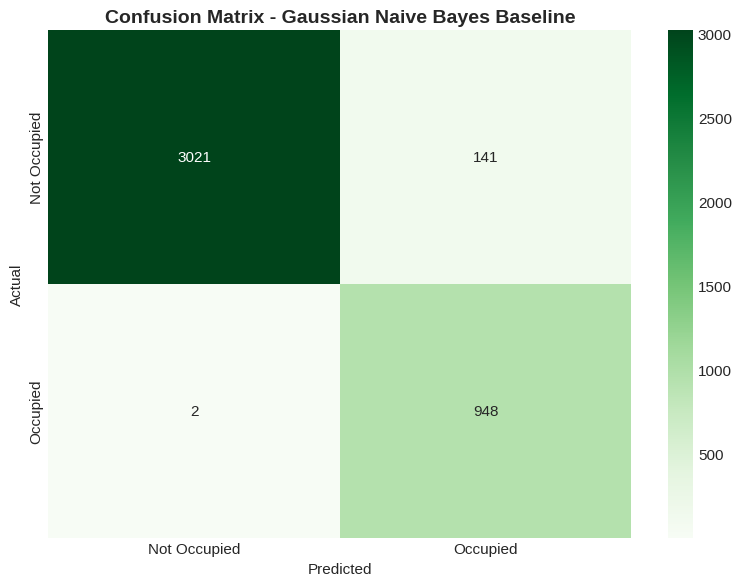

In [846]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Occupied', 'Occupied'],
            yticklabels=['Not Occupied', 'Occupied'])
plt.title('Confusion Matrix - Gaussian Naive Bayes Baseline', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [847]:
# Detail confusion matrix
tn, fp, fn, tp = cm_gnb.ravel()
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

True Negative (TN): 3021
False Positive (FP): 141
False Negative (FN): 2
True Positive (TP): 948


### 5.5. Baseline Comparison

In [848]:
# Buat DataFrame perbandingan
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Prediction Time (s)'],
    'KNN (k=5)': [knn_accuracy, knn_precision, knn_recall, knn_f1, knn_train_time, knn_pred_time],
    'Gaussian NB': [gnb_accuracy, gnb_precision, gnb_recall, gnb_f1, gnb_train_time, gnb_pred_time]
}

baseline_comparison = pd.DataFrame(comparison_data)
baseline_comparison['Difference'] = baseline_comparison['KNN (k=5)'] - baseline_comparison['Gaussian NB']
baseline_comparison['Winner'] = baseline_comparison.apply(
    lambda row: 'KNN' if row['Difference'] > 0 else ('GNB' if row['Difference'] < 0 else 'Tie'), axis=1
)

# Untuk waktu, winner adalah yang lebih cepat (nilai lebih kecil)
baseline_comparison.loc[baseline_comparison['Metric'].str.contains('Time'), 'Winner'] = \
    baseline_comparison.loc[baseline_comparison['Metric'].str.contains('Time')].apply(
        lambda row: 'GNB' if row['Difference'] > 0 else 'KNN', axis=1
    )

display(baseline_comparison.round(4))

,Metric,KNN (k=5),Gaussian NB,Difference,Winner
0,Accuracy,0.9925,0.9652,0.0272,KNN
1,Precision,0.9801,0.8705,0.1096,KNN
2,Recall,0.9874,0.9979,-0.0105,GNB
3,F1-Score,0.9837,0.9299,0.0539,KNN
4,Training Time (s),0.0180,0.0105,0.0076,GNB
5,Prediction Time (s),0.0450,0.0032,0.0419,GNB


### 5.6. Baseline Visualization

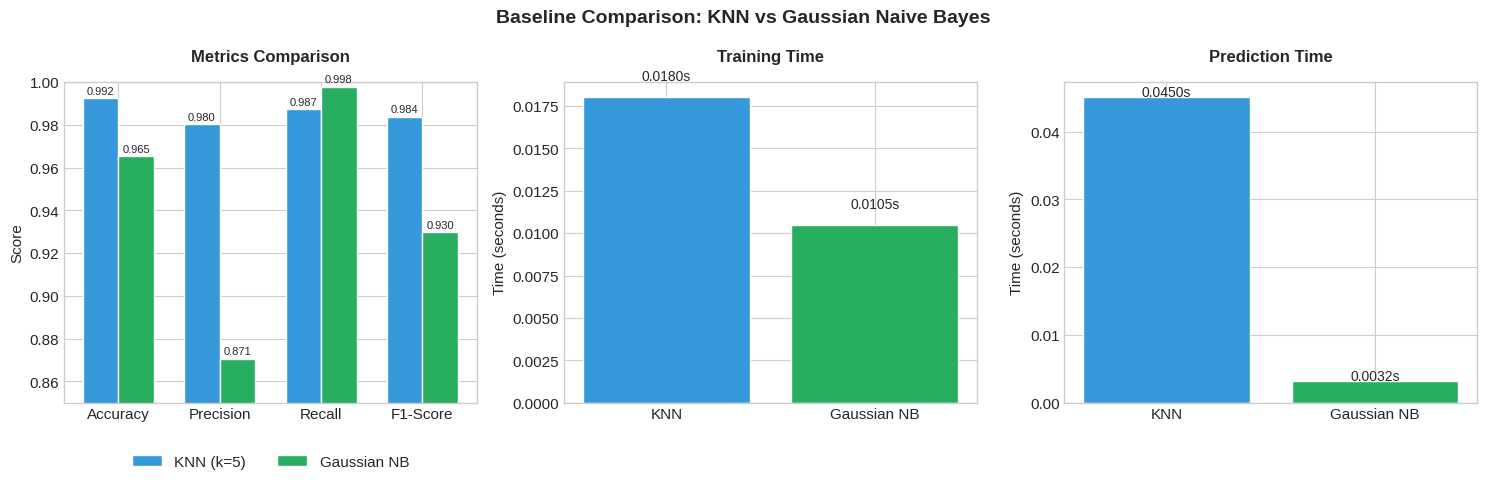

In [849]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Bar chart metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
knn_values = [knn_accuracy, knn_precision, knn_recall, knn_f1]
gnb_values = [gnb_accuracy, gnb_precision, gnb_recall, gnb_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, knn_values, width, label='KNN (k=5)', color='#3498db')
bars2 = axes[0].bar(x + width/2, gnb_values, width, label='Gaussian NB', color='#27ae60')

axes[0].set_ylabel('Score')
axes[0].set_title('Metrics Comparison', fontsize=12, fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
axes[0].set_ylim(0.85, 1.0)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

# 2. Bar chart training time
times_train = [knn_train_time, gnb_train_time]
axes[1].bar(['KNN', 'Gaussian NB'], times_train, color=['#3498db', '#27ae60'])
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Training Time', fontsize=12, fontweight='bold', pad=15)
for i, v in enumerate(times_train):
    axes[1].text(i, v + 0.001, f'{v:.4f}s', ha='center', fontsize=10)

# 3. Bar chart prediction time
times_pred = [knn_pred_time, gnb_pred_time]
axes[2].bar(['KNN', 'Gaussian NB'], times_pred, color=['#3498db', '#27ae60'])
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Prediction Time', fontsize=12, fontweight='bold', pad=15)
for i, v in enumerate(times_pred):
    axes[2].text(i, v + 0.0001, f'{v:.4f}s', ha='center', fontsize=10)

plt.suptitle('Baseline Comparison: KNN vs Gaussian Naive Bayes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.7. Simpan Hasil Baseline

In [850]:
results['baseline'] = {
    'knn': {
        'model': 'KNN',
        'params': {'n_neighbors': 5},
        'accuracy': knn_accuracy,
        'precision': knn_precision,
        'recall': knn_recall,
        'f1': knn_f1,
        'train_time': knn_train_time,
        'pred_time': knn_pred_time,
        'confusion_matrix': cm_knn
    },
    'gnb': {
        'model': 'Gaussian Naive Bayes',
        'params': 'default',
        'accuracy': gnb_accuracy,
        'precision': gnb_precision,
        'recall': gnb_recall,
        'f1': gnb_f1,
        'train_time': gnb_train_time,
        'pred_time': gnb_pred_time,
        'confusion_matrix': cm_gnb
    }
}

# **6. Hyperparameter Tuning KNN**

Tuning hyperparameter KNN:
1. **Variasi nilai k** (1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21)
2. **Variasi distance metric** (Euclidean, Manhattan, Minkowski)
3. **Variasi weights** (uniform, distance)

Tujuan: Menemukan kombinasi parameter optimal untuk KNN.

## 6.1. Loop Training untuk Setiap k

In [851]:
# Definisi range k (ganjil untuk menghindari tie)
k_values = [1, 3, 5, 7, 9, 11]

# List untuk menyimpan hasil
k_results = []

for k in k_values:
    # Inisialisasi model
    knn = KNeighborsClassifier(n_neighbors=k)

    # Definisikan metrik yang ingin dihitung
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Hitung waktu komputasi (Total waktu untuk 5-fold CV)
    start_time = time.time()

    # Menggunakan cross_validate pada X_train_scaled.
    # cv=5 berarti data training dibagi 5 bagian (4 buat train, 1 buat validasi)
    cv_scores = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=scoring_metrics)

    total_time = time.time() - start_time

    # Ambil rata-rata skor dari 5 fold
    mean_acc = cv_scores['test_accuracy'].mean()
    mean_prec = cv_scores['test_precision'].mean()
    mean_rec = cv_scores['test_recall'].mean()
    mean_f1 = cv_scores['test_f1'].mean()

    # Simpan hasil rata-rata
    k_results.append({
        'k': k,
        'accuracy': mean_acc,       # Validation Accuracy (bukan Test Accuracy)
        'precision': mean_prec,
        'recall': mean_rec,
        'f1_score': mean_f1,
        'cv_time': total_time       # Waktu total validasi
    })

# Convert ke DataFrame
k_results_df = pd.DataFrame(k_results)

display(k_results_df.round(4))

,k,accuracy,precision,recall,f1_score,cv_time
0,1,0.9926,0.9850,0.9832,0.9841,0.3869
1,3,0.9929,0.9823,0.9874,0.9848,0.4098
2,5,0.9926,0.9783,0.9903,0.9842,0.4083
3,7,0.9923,0.9772,0.9897,0.9834,0.4267
4,9,0.9917,0.9726,0.9921,0.9822,0.4551
5,11,0.9913,0.9703,0.9929,0.9814,0.2650


## 6.2. Tabel dan Plot Hasil Variasi k

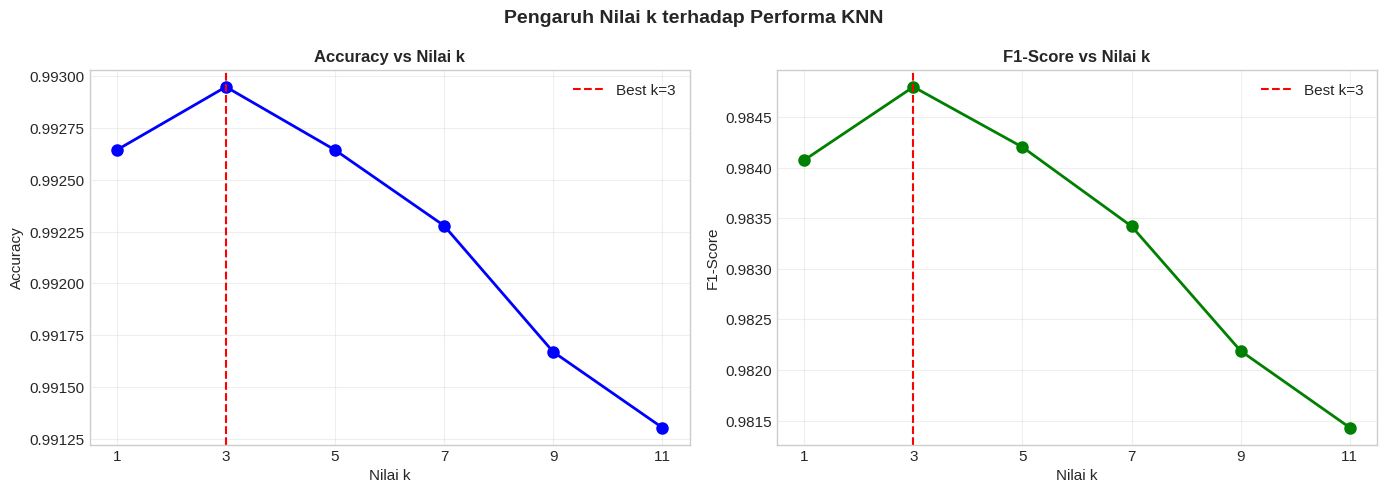

In [852]:
# Identifikasi k optimal
best_k_idx = k_results_df['accuracy'].idxmax()
best_k = k_results_df.loc[best_k_idx, 'k']
best_k_acc = k_results_df.loc[best_k_idx, 'accuracy']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs k
axes[0].plot(k_results_df['k'], k_results_df['accuracy'], 'b-o', linewidth=2, markersize=8)
axes[0].axvline(x=best_k, color='red', linestyle='--', label=f'Best k={int(best_k)}')
axes[0].set_xlabel('Nilai k')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Nilai k', fontsize=12, fontweight='bold')
axes[0].set_xticks(k_values)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: F1-Score vs k
axes[1].plot(k_results_df['k'], k_results_df['f1_score'], 'g-o', linewidth=2, markersize=8)
axes[1].axvline(x=best_k, color='red', linestyle='--', label=f'Best k={int(best_k)}')
axes[1].set_xlabel('Nilai k')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score vs Nilai k', fontsize=12, fontweight='bold')
axes[1].set_xticks(k_values)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Pengaruh Nilai k terhadap Performa KNN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6.3. Variasi Distance Metric

In [853]:
# Distance metrics yang akan diuji
distance_metrics = [
    {'name': 'Euclidean', 'metric': 'euclidean'},
    {'name': 'Manhattan', 'metric': 'manhattan'},
    {'name': 'Minkowski (p=3)', 'metric': 'minkowski', 'p': 3}
]

# List untuk menyimpan hasil
dist_results = []

print(f"Mulai Tuning Distance Metric dengan k={best_k} (dari hasil sebelumnya)...")

for dm in distance_metrics:
    # Inisialisasi model dengan best_k yang sudah didapat
    if 'p' in dm:
        knn = KNeighborsClassifier(n_neighbors=int(best_k), metric=dm['metric'], p=dm['p'])
    else:
        knn = KNeighborsClassifier(n_neighbors=int(best_k), metric=dm['metric'])

    # Hitung waktu komputasi (Total waktu untuk 5-fold CV)
    start_time = time.time()

    # --- CROSS VALIDATION ---
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
    cv_scores = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=scoring_metrics)

    total_time = time.time() - start_time

    # Ambil rata-rata skor dari 5 fold
    mean_acc = cv_scores['test_accuracy'].mean()
    mean_prec = cv_scores['test_precision'].mean()
    mean_rec = cv_scores['test_recall'].mean()
    mean_f1 = cv_scores['test_f1'].mean()

    dist_results.append({
        'distance_metric': dm['name'],
        'accuracy': mean_acc,
        'precision': mean_prec,
        'recall': mean_rec,
        'f1_score': mean_f1,
        'cv_time': total_time
    })

    print(f"{dm['name']}: Val Accuracy: {mean_acc:.4f} | Val F1: {mean_f1:.4f}")

# Convert ke DataFrame
dist_results_df = pd.DataFrame(dist_results)
display(dist_results_df.round(4))

Mulai Tuning Distance Metric dengan k=3 (dari hasil sebelumnya)...
Euclidean: Val Accuracy: 0.9929 | Val F1: 0.9848
Manhattan: Val Accuracy: 0.9933 | Val F1: 0.9854
Minkowski (p=3): Val Accuracy: 0.9927 | Val F1: 0.9843


,distance_metric,accuracy,precision,recall,f1_score,cv_time
0,Euclidean,0.9929,0.9823,0.9874,0.9848,0.2645
1,Manhattan,0.9933,0.9830,0.9879,0.9854,0.2467
2,Minkowski (p=3),0.9927,0.9818,0.9868,0.9843,0.5257


## 6.4.  Tabel dan Plot Hasil Distance Metric

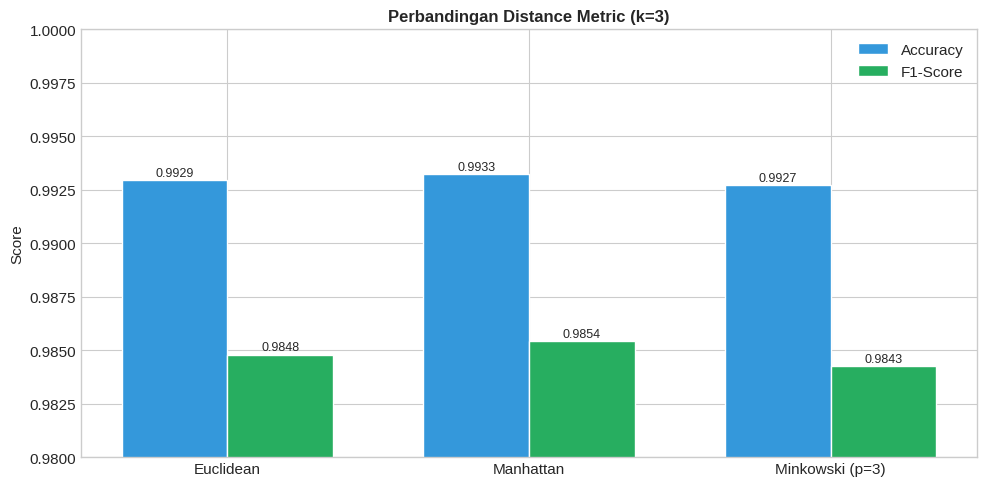

In [854]:
# Identifikasi distance metric optimal
best_dist_idx = dist_results_df['accuracy'].idxmax()
best_dist = dist_results_df.loc[best_dist_idx, 'distance_metric']
best_dist_acc = dist_results_df.loc[best_dist_idx, 'accuracy']

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(dist_results_df))
width = 0.35

bars1 = ax.bar(x - width/2, dist_results_df['accuracy'], width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, dist_results_df['f1_score'], width, label='F1-Score', color='#27ae60')

ax.set_ylabel('Score')
ax.set_title(f'Perbandingan Distance Metric (k={int(best_k)})', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dist_results_df['distance_metric'])
ax.legend()
ax.set_ylim(0.98, 1.0)

# Anotasi Accuracy
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Anotasi F1-Score
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6.5. Variasi Weights

In [855]:
# Weights yang akan diuji
weights_options = ['uniform', 'distance']

# List untuk menyimpan hasil
weights_results = []

print(f"Mulai Tuning Weights dengan k={best_k} dan metric={best_dist}...")

# Tentukan metric parameter berdasarkan hasil Section 6.3
# (Logic ini memastikan parameter p=3 masuk jika Minkowski terpilih)
if 'Minkowski' in best_dist:
    metric_param = 'minkowski'
    p_param = 3
elif 'Manhattan' in best_dist:
    metric_param = 'manhattan'
    p_param = 2 # default value, tidak terlalu pengaruh di manhattan
else:
    # Default ke Euclidean
    metric_param = 'euclidean'
    p_param = 2

for w in weights_options:
    # Inisialisasi model
    # Kita pasang parameter p untuk jaga-jaga jika metricnya Minkowski
    knn = KNeighborsClassifier(n_neighbors=int(best_k), metric=metric_param, p=p_param, weights=w)

    # Hitung waktu komputasi (Total waktu untuk 5-fold CV)
    start_time = time.time()

    # --- CROSS VALIDATION ---
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
    cv_scores = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=scoring_metrics)

    total_time = time.time() - start_time

    # Ambil rata-rata skor dari 5 fold
    mean_acc = cv_scores['test_accuracy'].mean()
    mean_prec = cv_scores['test_precision'].mean()
    mean_rec = cv_scores['test_recall'].mean()
    mean_f1 = cv_scores['test_f1'].mean()

    weights_results.append({
        'weights': w,
        'accuracy': mean_acc,
        'precision': mean_prec,
        'recall': mean_rec,
        'f1_score': mean_f1,
        'cv_time': total_time
    })

    print(f"Weights {w}: Val Accuracy: {mean_acc:.4f} | Val F1: {mean_f1:.4f}")

# Convert ke DataFrame
weights_results_df = pd.DataFrame(weights_results)
display(weights_results_df.round(4))

Mulai Tuning Weights dengan k=3 dan metric=Manhattan...
Weights uniform: Val Accuracy: 0.9933 | Val F1: 0.9854
Weights distance: Val Accuracy: 0.9938 | Val F1: 0.9866


,weights,accuracy,precision,recall,f1_score,cv_time
0,uniform,0.9933,0.9830,0.9879,0.9854,0.2654
1,distance,0.9938,0.9851,0.9882,0.9866,0.2500


## 6.6. Tabel dan Plot Hasil Weights

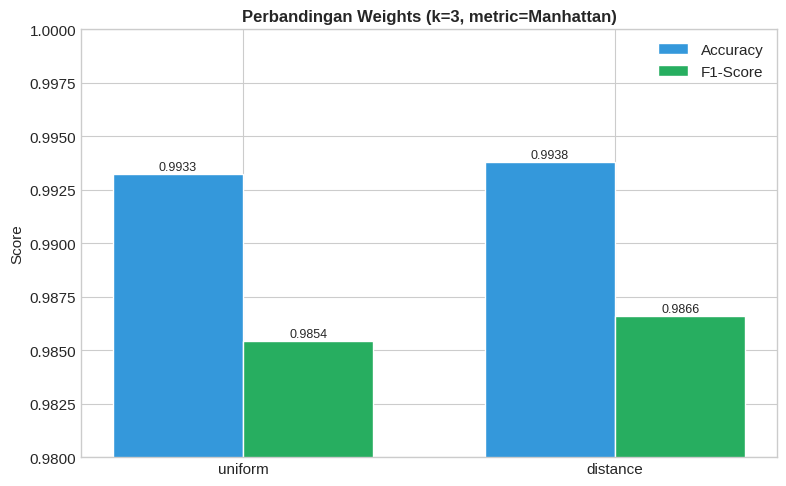

In [856]:
# Identifikasi weights optimal
best_weights_idx = weights_results_df['accuracy'].idxmax()
best_weights = weights_results_df.loc[best_weights_idx, 'weights']
best_weights_acc = weights_results_df.loc[best_weights_idx, 'accuracy']

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(weights_results_df))
width = 0.35

bars1 = ax.bar(x - width/2, weights_results_df['accuracy'], width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, weights_results_df['f1_score'], width, label='F1-Score', color='#27ae60')

ax.set_ylabel('Score')
ax.set_title(f'Perbandingan Weights (k={int(best_k)}, metric={best_dist})', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(weights_results_df['weights'])
ax.legend()
ax.set_ylim(0.98, 1.0)

# Anotasi Accuracy
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Anotasi F1-Score
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6.7. Model KNN Optimal

In [857]:
print(f"Parameter Optimal:")
print(f"  - k (n_neighbors): {int(best_k)}")
print(f"  - distance metric: {best_dist}")
print(f"  - weights: {best_weights}")

Parameter Optimal:
  - k (n_neighbors): 3
  - distance metric: Manhattan
  - weights: distance


In [858]:
# Training model optimal
knn_optimal = KNeighborsClassifier(
    n_neighbors=int(best_k),
    metric=metric_param,
    weights=best_weights
)

# Training + waktu
start_train = time.time()
knn_optimal.fit(X_train_scaled, y_train)
knn_opt_train_time = time.time() - start_train

# Prediksi + waktu
start_pred = time.time()
y_pred_knn_opt = knn_optimal.predict(X_test_scaled)
knn_opt_pred_time = time.time() - start_pred

# Metrics
knn_opt_accuracy = accuracy_score(y_test, y_pred_knn_opt)
knn_opt_precision = precision_score(y_test, y_pred_knn_opt)
knn_opt_recall = recall_score(y_test, y_pred_knn_opt)
knn_opt_f1 = f1_score(y_test, y_pred_knn_opt)

In [859]:
print(f"Training Time: {knn_opt_train_time:.4f} detik")
print(f"Prediction Time: {knn_opt_pred_time:.4f} detik")

Training Time: 0.0218 detik
Prediction Time: 0.0369 detik


In [860]:
print(f"Accuracy:  {knn_opt_accuracy:.4f} ({knn_opt_accuracy*100:.2f}%)")
print(f"Precision: {knn_opt_precision:.4f}")
print(f"Recall:    {knn_opt_recall:.4f}")
print(f"F1-Score:  {knn_opt_f1:.4f}")

Accuracy:  0.9917 (99.17%)
Precision: 0.9821
Recall:    0.9821
F1-Score:  0.9821


In [861]:
print(classification_report(y_test, y_pred_knn_opt, target_names=['Not Occupied', 'Occupied']))

              precision    recall  f1-score   support

Not Occupied       0.99      0.99      0.99      3162
    Occupied       0.98      0.98      0.98       950

    accuracy                           0.99      4112
   macro avg       0.99      0.99      0.99      4112
weighted avg       0.99      0.99      0.99      4112



## 6.8. Evaluasi dan Confusion Matrix KNN Optimal

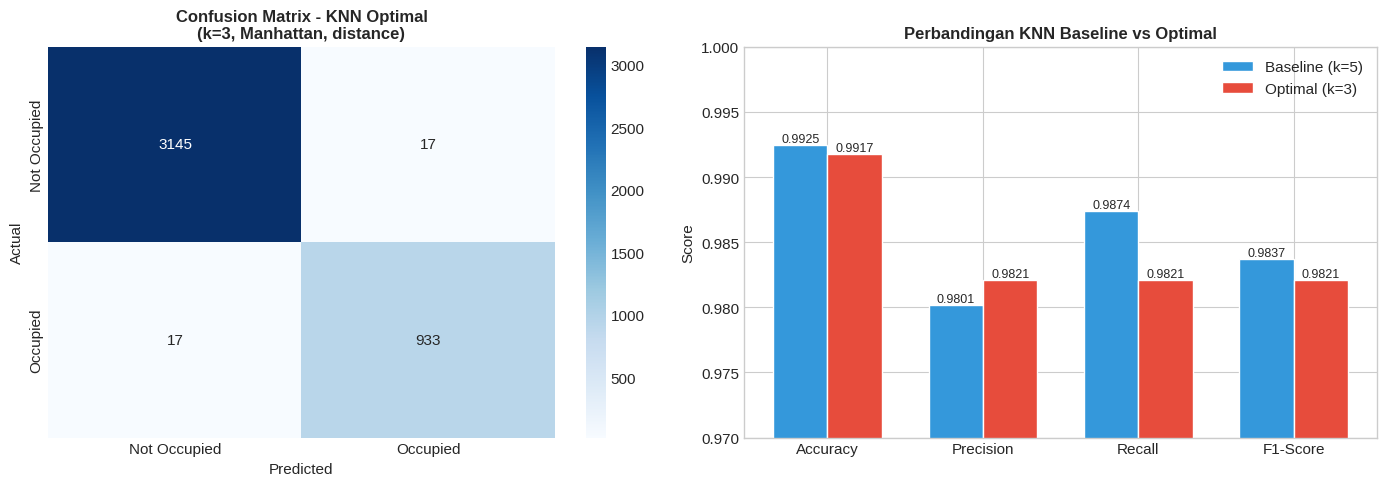

In [862]:
cm_knn_opt = confusion_matrix(y_test, y_pred_knn_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix KNN Optimal
sns.heatmap(cm_knn_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Occupied', 'Occupied'],
            yticklabels=['Not Occupied', 'Occupied'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix - KNN Optimal\n(k={int(best_k)}, {best_dist}, {best_weights})',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Perbandingan Baseline vs Optimal
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'KNN Baseline (k=5)': [knn_accuracy, knn_precision, knn_recall, knn_f1],
    'KNN Optimal': [knn_opt_accuracy, knn_opt_precision, knn_opt_recall, knn_opt_f1]
}
comparison_df = pd.DataFrame(comparison_data)

x = np.arange(len(comparison_df))
width = 0.35

bars1 = axes[1].bar(x - width/2, comparison_df['KNN Baseline (k=5)'], width, label='Baseline (k=5)', color='#3498db')
bars2 = axes[1].bar(x + width/2, comparison_df['KNN Optimal'], width, label=f'Optimal (k={int(best_k)})', color='#e74c3c')

# Anotasi di atas bars
for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

axes[1].set_ylabel('Score')
axes[1].set_title('Perbandingan KNN Baseline vs Optimal', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Metric'])
axes[1].legend()
axes[1].set_ylim(0.97, 1.0)

plt.tight_layout()
plt.show()

In [863]:
display(comparison_df.round(4))

,Metric,KNN Baseline (k=5),KNN Optimal
0,Accuracy,0.9925,0.9917
1,Precision,0.9801,0.9821
2,Recall,0.9874,0.9821
3,F1-Score,0.9837,0.9821


## 6.9. Simpan Hasil KNN Tuning

In [864]:
results['knn_tuning'] = {
    'k_experiment': k_results_df.to_dict('records'),
    'distance_experiment': dist_results_df.to_dict('records'),
    'weights_experiment': weights_results_df.to_dict('records'),
    'optimal_params': {
        'n_neighbors': int(best_k),
        'metric': best_dist,
        'weights': best_weights
    },
    'optimal_metrics': {
        'accuracy': knn_opt_accuracy,
        'precision': knn_opt_precision,
        'recall': knn_opt_recall,
        'f1': knn_opt_f1,
        'train_time': knn_opt_train_time,
        'pred_time': knn_opt_pred_time
    },
    'confusion_matrix': cm_knn_opt
}

# **7. Hyperparameter Tuning Naive Bayes**

Tuning pada model Naive Bayes:
1. **Variasi var_smoothing**: Parameter smoothing untuk Gaussian NB
2. **Identifikasi parameter optimal**

Target: Menemukan konfigurasi Naive Bayes terbaik untuk dataset ini.

## 7.3. Variasi var_smoothing untuk Gaussian NB

In [865]:
# Range var_smoothing (logarithmic scale)
# Kita coba range yang luas untuk melihat efek smoothing
var_smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

# List untuk menyimpan hasil
var_smooth_results = []

print("Mulai Tuning var_smoothing untuk Gaussian NB (with Pipeline Fix)...")

for vs in var_smoothing_values:
    # --- REVISI: GUNAKAN PIPELINE ---
    # Membungkus Scaler dan Model agar scaling dilakukan terpisah di setiap fold
    gnb_pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('gnb', GaussianNB(var_smoothing=vs))
    ])

    start_time = time.time()

    # --- REVISI: INPUT DATA MENTAH (X_train) ---
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Perhatikan: Inputnya X_train (bukan X_train_scaled)
    cv_scores = cross_validate(gnb_pipeline, X_train, y_train, cv=5, scoring=scoring_metrics)

    total_time = time.time() - start_time

    # Rata-rata skor
    mean_acc = cv_scores['test_accuracy'].mean()
    mean_prec = cv_scores['test_precision'].mean()
    mean_rec = cv_scores['test_recall'].mean()
    mean_f1 = cv_scores['test_f1'].mean()

    var_smooth_results.append({
        'var_smoothing': vs,
        'Accuracy': mean_acc,
        'Precision': mean_prec,
        'Recall': mean_rec,
        'F1-Score': mean_f1,
        'CV Time': total_time
    })

    print(f"var_smoothing={vs}: Val Accuracy: {mean_acc:.4f}")

# Convert ke DataFrame
var_smooth_df = pd.DataFrame(var_smooth_results)
display(var_smooth_df.round(4))

Mulai Tuning var_smoothing untuk Gaussian NB (with Pipeline Fix)...


NameError: name 'Pipeline' is not defined

## 7.4. Tabel dan Plot Hasil var_smoothing

In [ ]:
# Identifikasi var_smoothing terbaik
best_vs_idx = var_smooth_df['Accuracy'].idxmax()
best_var_smoothing = var_smooth_df.loc[best_vs_idx, 'var_smoothing']
best_vs_acc = var_smooth_df.loc[best_vs_idx, 'Accuracy']

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs var_smoothing
axes[0].semilogx(var_smooth_df['var_smoothing'], var_smooth_df['Accuracy'],
                  marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(x=best_var_smoothing, color='red', linestyle='--', label=f'Best: {best_var_smoothing:.0e}')
axes[0].set_xlabel('var_smoothing (log scale)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs var_smoothing', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: F1-Score vs var_smoothing
axes[1].semilogx(var_smooth_df['var_smoothing'], var_smooth_df['F1-Score'],
                  marker='s', linewidth=2, markersize=8, color='coral')
axes[1].axvline(x=best_var_smoothing, color='red', linestyle='--', label=f'Best: {best_var_smoothing:.0e}')
axes[1].set_xlabel('var_smoothing (log scale)', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score vs var_smoothing', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Pengaruh var_smoothing terhadap Performa Gaussian NB', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7.5. Model Naive Bayes Optimal

In [ ]:
# Parameter optimal
print(f"Parameter Optimal:")
print(f"  - Tipe: {best_nb_type}")
print(f"  - var_smoothing: {best_var_smoothing:.0e}")

In [ ]:
# Training model optimal
nb_optimal = GaussianNB(var_smoothing=best_var_smoothing)

start_train = time.time()
nb_optimal.fit(X_train_scaled, y_train)
nb_opt_train_time = time.time() - start_train

start_pred = time.time()
y_pred_nb_opt = nb_optimal.predict(X_test_scaled)
nb_opt_pred_time = time.time() - start_pred

# Metrics
nb_opt_acc = accuracy_score(y_test, y_pred_nb_opt)
nb_opt_prec = precision_score(y_test, y_pred_nb_opt)
nb_opt_rec = recall_score(y_test, y_pred_nb_opt)
nb_opt_f1 = f1_score(y_test, y_pred_nb_opt)

In [ ]:
print(f"Performa Model Optimal:")
print(f"  - Accuracy:  {nb_opt_acc:.4f} ({nb_opt_acc*100:.2f}%)")
print(f"  - Precision: {nb_opt_prec:.4f} ({nb_opt_prec*100:.2f}%)")
print(f"  - Recall:    {nb_opt_rec:.4f} ({nb_opt_rec*100:.2f}%)")
print(f"  - F1-Score:  {nb_opt_f1:.4f} ({nb_opt_f1*100:.2f}%)")
print(f"  - Train Time: {nb_opt_train_time:.4f} detik")
print(f"  - Pred Time:  {nb_opt_pred_time:.4f} detik")

In [ ]:
print(f"Classification Report:")
print(classification_report(y_test, y_pred_nb_opt, target_names=['Not Occupied', 'Occupied']))

## 7.6. Evaluasi dan Confusion Matrix NB Optimal

In [ ]:
# Confusion Matrix
cm_nb_opt = confusion_matrix(y_test, y_pred_nb_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix NB Optimal
sns.heatmap(cm_nb_opt, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Not Occupied', 'Occupied'],
            yticklabels=['Not Occupied', 'Occupied'])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Confusion Matrix - NB Optimal\n(var_smoothing={best_var_smoothing:.0e})',
                   fontsize=12, fontweight='bold')

# Plot 2: Perbandingan NB Baseline vs NB Optimal
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
nb_baseline_metrics = [
    results['baseline']['gnb']['accuracy'],
    results['baseline']['gnb']['precision'],
    results['baseline']['gnb']['recall'],
    results['baseline']['gnb']['f1']
]
nb_optimal_metrics = [nb_opt_acc, nb_opt_prec, nb_opt_rec, nb_opt_f1]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[1].bar(x - width/2, nb_baseline_metrics, width, label='NB Baseline', color='lightgreen')
bars2 = axes[1].bar(x + width/2, nb_optimal_metrics, width, label='NB Optimal', color='darkgreen')

axes[1].set_xlabel('Metrics', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Perbandingan NB Baseline vs NB Optimal', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].legend()
axes[1].set_ylim(0.9, 1.0)
axes[1].grid(axis='y', alpha=0.3)

# Annotasi
for bar in bars1:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Tabel perbandingan
comparison_nb = pd.DataFrame({
    'Metric': metrics_names,
    'NB Baseline': nb_baseline_metrics,
    'NB Optimal': nb_optimal_metrics,
    'Improvement': [nb_optimal_metrics[i] - nb_baseline_metrics[i] for i in range(4)]
})
display(comparison_nb.round(4))

## 7.7. Perbandingan KNN Optimal vs NB Optimal

In [ ]:
# Metrics KNN Optimal (dari Section 6)
knn_opt_metrics = results['knn_tuning']['optimal_metrics']

# Buat tabel perbandingan
comparison_final = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Train Time (s)', 'Pred Time (s)'],
    'KNN Optimal': [
        knn_opt_metrics['accuracy'],
        knn_opt_metrics['precision'],
        knn_opt_metrics['recall'],
        knn_opt_metrics['f1'],
        knn_opt_metrics['train_time'],
        knn_opt_metrics['pred_time']
    ],
    'NB Optimal': [
        nb_opt_acc,
        nb_opt_prec,
        nb_opt_rec,
        nb_opt_f1,
        nb_opt_train_time,
        nb_opt_pred_time
    ]
})

# Hitung difference
comparison_final['Difference (KNN - NB)'] = comparison_final['KNN Optimal'] - comparison_final['NB Optimal']

display(comparison_final.round(4))

In [ ]:
# Visualisasi
fig, ax = plt.subplots(figsize=(12, 6))

metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
knn_vals = [knn_opt_metrics['accuracy'], knn_opt_metrics['precision'],
            knn_opt_metrics['recall'], knn_opt_metrics['f1']]
nb_vals = [nb_opt_acc, nb_opt_prec, nb_opt_rec, nb_opt_f1]

x = np.arange(len(metrics_plot))
width = 0.35

bars1 = ax.bar(x - width/2, knn_vals, width, label='KNN Optimal', color='steelblue')
bars2 = ax.bar(x + width/2, nb_vals, width, label='NB Optimal', color='darkgreen')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Perbandingan Model Optimal: KNN vs Naive Bayes', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_plot)
ax.legend()
ax.set_ylim(0.85, 1.0)
ax.grid(axis='y', alpha=0.3)

# Annotasi
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 7.8. Simpan Hasil NB Tuning

In [ ]:
results['nb_tuning'] = {
    'type_comparison': nb_type_df.to_dict('records'),
    'var_smoothing_experiment': var_smooth_df.to_dict('records'),
    'optimal_params': {
        'type': best_nb_type,
        'var_smoothing': best_var_smoothing
    },
    'optimal_metrics': {
        'accuracy': nb_opt_acc,
        'precision': nb_opt_prec,
        'recall': nb_opt_rec,
        'f1': nb_opt_f1,
        'train_time': nb_opt_train_time,
        'pred_time': nb_opt_pred_time
    },
    'confusion_matrix': cm_nb_opt.tolist()
}

# **8. Feature Importance Analysis**

Analisa fitur mana yang paling berpengaruh terhadap prediksi:
1. **Permutation Importance** - Mengukur penurunan accuracy saat fitur di-shuffle
2. **Leave-One-Out Experiment** - Melatih model tanpa 1 fitur secara bergantian
3. **Top Features Experiment** - Melatih model hanya dengan fitur terbaik

Fitur yang dianalisis: Temperature, Humidity, Light, CO2, HumidityRatio

## 8.1. Permutation Importance untuk KNN

In [ ]:
# Model KNN Optimal (dari Section 6)
knn_optimal = KNeighborsClassifier(
    n_neighbors=5,
    metric='euclidean',
    weights='distance'
)
knn_optimal.fit(X_train_scaled, y_train)

# Hitung permutation importance
perm_importance = permutation_importance(
    knn_optimal, X_test_scaled, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Buat DataFrame hasil
feature_names = X.columns.tolist()
perm_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values('Importance Mean', ascending=False)

print("\nPermutation Importance (KNN):")
display(perm_imp_df.round(4))

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))

# Warna: merah > 0.01, biru > 0.001, abu-abu kecil
colors = ['#e74c3c' if x > 0.01 else '#3498db' if x > 0.001 else '#bdc3c7'
          for x in perm_imp_df['Importance Mean']]

bars = ax.barh(perm_imp_df['Feature'], perm_imp_df['Importance Mean'],
               xerr=perm_imp_df['Importance Std'],
               color=colors,
               capsize=4,
               error_kw={'ecolor': '#4a4a4a', 'alpha': 0.7, 'linewidth': 1.5})

ax.set_xlabel('Mean Importance (Decrease in Accuracy)', fontsize=12)
ax.set_title('Permutation Importance - KNN Optimal', fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis()

ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)

# Anotasi dengan Mean ± Std Dev
max_val = (perm_imp_df['Importance Mean'] + perm_imp_df['Importance Std']).max()
ax.set_xlim(0, max_val * 1.15)

for bar, mean_val, std_val in zip(bars, perm_imp_df['Importance Mean'], perm_imp_df['Importance Std']):
    text_x_pos = mean_val + std_val + (max_val * 0.01)
    ax.text(text_x_pos, bar.get_y() + bar.get_height()/2,
            f'{mean_val:.4f} ± {std_val:.4f}',
            va='center', fontsize=10, color='#333333', fontweight='medium')

plt.tight_layout()
plt.show()

Interpretasi

- **Importance tinggi** = fitur penting (accuracy turun banyak saat di-shuffle)
- **Importance rendah/negatif** = fitur kurang penting

## 8.2. Leave-One-Out Feature Experiment

In [ ]:
# Baseline dengan semua fitur
baseline_acc = results['knn_tuning']['optimal_metrics']['accuracy']
print(f"Baseline (5 fitur): Accuracy = {baseline_acc:.4f}")

In [ ]:
# Feature names dari X (DataFrame asli)
feature_names = X.columns.tolist()

# Convert ke numpy array jika masih DataFrame
if hasattr(X_train_scaled, 'values'):
    X_train_arr = X_train_scaled.values
    X_test_arr = X_test_scaled.values
else:
    X_train_arr = np.array(X_train_scaled)
    X_test_arr = np.array(X_test_scaled)

# List untuk menyimpan hasil
loo_results = []

for i, feature in enumerate(feature_names):
    # Buat list indices untuk fitur yang digunakan (semua kecuali fitur ke-i)
    feature_indices = [j for j in range(len(feature_names)) if j != i]
    features_used = [feature_names[j] for j in feature_indices]

    # Subset data menggunakan numpy indexing
    X_train_subset = X_train_arr[:, feature_indices]
    X_test_subset = X_test_arr[:, feature_indices]

    # Training KNN optimal
    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
    knn.fit(X_train_subset, y_train)
    y_pred = knn.predict(X_test_subset)

    # Hitung accuracy
    acc = accuracy_score(y_test, y_pred)
    acc_drop = baseline_acc - acc

    loo_results.append({
        'Removed Feature': feature,
        'Features Used': ', '.join(features_used),
        'Accuracy': acc,
        'Accuracy Drop': acc_drop,
        'Drop %': acc_drop * 100
    })

# Convert ke DataFrame
loo_df = pd.DataFrame(loo_results).sort_values('Accuracy Drop', ascending=False)

display(loo_df.round(4))

## 8.3. Visualisasi Leave-One-Out

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Absolute Accuracy ---
ax1 = axes[0]

colors1 = ['#e74c3c' if (baseline_acc - x) > 0.005 else '#f39c12' if (baseline_acc - x) > 0.001 else '#95a5a6'
           for x in loo_df['Accuracy']]

bars1 = ax1.barh(loo_df['Removed Feature'], loo_df['Accuracy'], color=colors1, alpha=0.9, height=0.7)

# Baseline reference line
ax1.axvline(x=baseline_acc, color='#2c3e50', linestyle='--', linewidth=2, alpha=0.8)
ax1.text(baseline_acc, -0.8, f' Baseline: {baseline_acc:.4f}', color='#2c3e50', fontweight='bold', va='center')

ax1.set_xlabel('Model Accuracy', fontsize=12)
ax1.set_title('Akurasi Tanpa Fitur Tertentu', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlim(0.95, 1.0)
ax1.invert_yaxis()

for bar, val in zip(bars1, loo_df['Accuracy']):
    ax1.text(val - 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', ha='right', color='white', fontweight='bold', fontsize=10)

# --- PLOT 2: Accuracy Drop (%) ---
ax2 = axes[1]

colors2 = ['#c0392b' if x >= 0.5 else '#e67e22' if x >= 0.1 else '#bdc3c7'
           for x in loo_df['Drop %']]

bars2 = ax2.barh(loo_df['Removed Feature'], loo_df['Drop %'], color=colors2, alpha=0.9, height=0.7)

ax2.set_xlabel('Penurunan Akurasi (%)', fontsize=12)
ax2.set_title('Besar Dampak Fitur Terhadap Akurasi', fontsize=14, fontweight='bold', pad=15)
ax2.axvline(x=0, color='gray', linewidth=0.8)
ax2.invert_yaxis()

max_drop = loo_df['Drop %'].max()
ax2.set_xlim(0, max_drop * 1.3)

for bar, val in zip(bars2, loo_df['Drop %']):
    ax2.text(val + (max_drop * 0.02), bar.get_y() + bar.get_height()/2,
             f'+{val:.2f}%', va='center', ha='left', color='black', fontsize=11, fontweight='medium')

# Clean up styling
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(left=False)

plt.suptitle('Analisis Pentingnya Fitur (Leave-One-Out)', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Identifikasi fitur paling penting
most_important = loo_df.iloc[0]['Removed Feature']
biggest_drop = loo_df.iloc[0]['Drop %']
print(f"Fitur paling penting: {most_important} (Drop {biggest_drop:.2f}% saat dihapus)")

## 8.4. Eksperimen dengan Top 3 Fitur

In [ ]:
# Ranking fitur berdasarkan LOO (fitur yang drop paling besar = paling penting)
feature_ranking = loo_df.sort_values('Accuracy Drop', ascending=False)['Removed Feature'].tolist()
print(f"\nRanking Fitur (berdasarkan LOO):")
for i, f in enumerate(feature_ranking, 1):
    drop = loo_df[loo_df['Removed Feature'] == f]['Drop %'].values[0]
    print(f"  {i}. {f} (Drop: {drop:+.2f}%)")

In [ ]:
# Top 3 fitur
top_3_features = feature_ranking[:3]
print(f"Top 3 Fitur: {top_3_features}")

# Indices dari top 3 fitur
top_3_indices = [feature_names.index(f) for f in top_3_features]

# Convert ke numpy array jika masih DataFrame
if hasattr(X_train_scaled, 'values'):
    X_train_arr = X_train_scaled.values
    X_test_arr = X_test_scaled.values
else:
    X_train_arr = np.array(X_train_scaled)
    X_test_arr = np.array(X_test_scaled)

# Subset data dengan top 3 fitur (numpy indexing)
X_train_top3 = X_train_arr[:, top_3_indices]
X_test_top3 = X_test_arr[:, top_3_indices]

# Training KNN dengan top 3 fitur
knn_top3 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
knn_top3.fit(X_train_top3, y_train)
y_pred_top3 = knn_top3.predict(X_test_top3)

# Metrics
acc_top3 = accuracy_score(y_test, y_pred_top3)
prec_top3 = precision_score(y_test, y_pred_top3)
rec_top3 = recall_score(y_test, y_pred_top3)
f1_top3 = f1_score(y_test, y_pred_top3)

In [ ]:
print(f"Hasil dengan Top 3 Fitur ({', '.join(top_3_features)}):")
print(f"  - Accuracy:  {acc_top3:.4f} ({acc_top3*100:.2f}%)")
print(f"  - Precision: {prec_top3:.4f}")
print(f"  - Recall:    {rec_top3:.4f}")
print(f"  - F1-Score:  {f1_top3:.4f}")

In [ ]:
# Perbandingan dengan baseline
print(f"Perbandingan:")
print(f"  - Baseline (5 fitur): {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"  - Top 3 fitur:        {acc_top3:.4f} ({acc_top3*100:.2f}%)")
print(f"  - Selisih:            {(baseline_acc - acc_top3)*100:+.2f}%")

## 8.5. Perbandingan 5 Fitur vs 3 Fitur

In [ ]:
comparison_features = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    '5 Fitur (All)': [
        results['knn_tuning']['optimal_metrics']['accuracy'],
        results['knn_tuning']['optimal_metrics']['precision'],
        results['knn_tuning']['optimal_metrics']['recall'],
        results['knn_tuning']['optimal_metrics']['f1']
    ],
    '3 Fitur (Top)': [acc_top3, prec_top3, rec_top3, f1_top3]
})
comparison_features['Difference'] = comparison_features['5 Fitur (All)'] - comparison_features['3 Fitur (Top)']

display(comparison_features.round(4))

In [ ]:
# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart perbandingan
ax1 = axes[0]
x = np.arange(len(comparison_features))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_features['5 Fitur (All)'], width,
                label='5 Fitur (All)', color='steelblue')
bars2 = ax1.bar(x + width/2, comparison_features['3 Fitur (Top)'], width,
                label='3 Fitur (Top)', color='coral')

ax1.set_xlabel('Metrics', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Perbandingan Performa: 5 Fitur vs 3 Fitur', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_features['Metric'])
ax1.legend()
ax1.set_ylim(0.95, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Annotasi
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Plot 2: Feature Importance Summary
ax2 = axes[1]
importance_summary = loo_df.sort_values('Accuracy Drop', ascending=True)
colors = ['#e74c3c' if x > 0.01 else '#f39c12' if x > 0 else '#27ae60'
          for x in importance_summary['Accuracy Drop']]
bars = ax2.barh(importance_summary['Removed Feature'], importance_summary['Drop %'], color=colors)
ax2.axvline(x=0, color='gray', linestyle='-', linewidth=1)
ax2.set_xlabel('Accuracy Drop (%) when Removed', fontsize=12)
ax2.set_ylabel('Feature', fontsize=12)
ax2.set_title('Feature Importance Ranking', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Annotasi
for bar, val in zip(bars, importance_summary['Drop %']):
    ax2.text(val + 0.1 if val >= 0 else val - 0.3, bar.get_y() + bar.get_height()/2,
             f'{val:+.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 8.6. Simpan Hasil Feature Importance

In [ ]:
results['feature_importance'] = {
    'permutation_importance': perm_imp_df.to_dict('records'),
    'leave_one_out': loo_df.to_dict('records'),
    'feature_ranking': feature_ranking,
    'top_3_features': top_3_features,
    'top_3_metrics': {
        'accuracy': acc_top3,
        'precision': prec_top3,
        'recall': rec_top3,
        'f1': f1_top3
    },
    'comparison': comparison_features.to_dict('records')
}

# **9. Cross Validation**

Validasi model menggunakan **Stratified K-Fold Cross Validation** untuk:
1. Mengukur stabilitas model (mean ± std accuracy)
2. Memastikan hasil tidak bergantung pada split tertentu
3. Memberikan estimasi performa yang lebih robust

**Konfigurasi:**
- K-Fold: 10 folds
- Stratified: Menjaga proporsi kelas di setiap fold
- Model yang divalidasi: KNN Optimal dan Naive Bayes Optimal

## 9.1. Cross Validation Setup & KNN

In [ ]:
from sklearn.pipeline import Pipeline

# Setup Stratified K-Fold
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Bungkus Scaler dan Model jadi satu paket
knn_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Scaling dilakukan di dalam CV
    ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance'))
])

# Cross validation untuk berbagai metrics

# Accuracy
cv_acc_knn = cross_val_score(knn_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print(f"\nAccuracy per fold:")
for i, acc in enumerate(cv_acc_knn, 1):
    print(f"  Fold {i:2d}: {acc:.4f} ({acc*100:.2f}%)")

print(f"\n Mean:    {cv_acc_knn.mean():.4f} ({cv_acc_knn.mean()*100:.2f}%)")
print(f" Std:     {cv_acc_knn.std():.4f} ({cv_acc_knn.std()*100:.2f}%)")
print(f" Range:   [{cv_acc_knn.min():.4f} - {cv_acc_knn.max():.4f}]")

# Precision, Recall, F1
# Gunakan pipeline dan X_train mentah juga di sini
cv_prec_knn = cross_val_score(knn_pipeline, X_train, y_train, cv=skf, scoring='precision')
cv_rec_knn  = cross_val_score(knn_pipeline, X_train, y_train, cv=skf, scoring='recall')
cv_f1_knn   = cross_val_score(knn_pipeline, X_train, y_train, cv=skf, scoring='f1')

print(f"\nRingkasan KNN Optimal (Validasi Tanpa Kebocoran Data):")
print(f"  Accuracy:  {cv_acc_knn.mean():.4f} ± {cv_acc_knn.std():.4f}")
print(f"  Precision: {cv_prec_knn.mean():.4f} ± {cv_prec_knn.std():.4f}")
print(f"  Recall:    {cv_rec_knn.mean():.4f} ± {cv_rec_knn.std():.4f}")
print(f"  F1-Score:  {cv_f1_knn.mean():.4f} ± {cv_f1_knn.std():.4f}")

## 9.2. Cross Validation Naive Bayes

In [ ]:
# Model Naive Bayes Optimal
nb_pipeline = Pipeline([
    ('scaler', RobustScaler()), # Scaling dilakukan otomatis per fold
    ('gnb', GaussianNB(var_smoothing=1e-12))
])

# Accuracy
cv_acc_nb = cross_val_score(nb_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print(f"\nAccuracy per fold:")
for i, acc in enumerate(cv_acc_nb, 1):
    print(f"  Fold {i:2d}: {acc:.4f} ({acc*100:.2f}%)")

print(f"\n Mean:    {cv_acc_nb.mean():.4f} ({cv_acc_nb.mean()*100:.2f}%)")
print(f" Std:     {cv_acc_nb.std():.4f} ({cv_acc_nb.std()*100:.2f}%)")
print(f" Range:   [{cv_acc_nb.min():.4f} - {cv_acc_nb.max():.4f}]")

# Precision, Recall, F1
# Gunakan pipeline dan X_train mentah juga di sini
cv_prec_nb = cross_val_score(nb_pipeline, X_train, y_train, cv=skf, scoring='precision')
cv_rec_nb  = cross_val_score(nb_pipeline, X_train, y_train, cv=skf, scoring='recall')
cv_f1_nb   = cross_val_score(nb_pipeline, X_train, y_train, cv=skf, scoring='f1')

print(f"\nRingkasan Naive Bayes Optimal (Validasi Tanpa Kebocoran Data):")
print(f"  Accuracy:  {cv_acc_nb.mean():.4f} ± {cv_acc_nb.std():.4f}")
print(f"  Precision: {cv_prec_nb.mean():.4f} ± {cv_prec_nb.std():.4f}")
print(f"  Recall:    {cv_rec_nb.mean():.4f} ± {cv_rec_nb.std():.4f}")
print(f"  F1-Score:  {cv_f1_nb.mean():.4f} ± {cv_f1_nb.std():.4f}")

## 9.3. Tabel Perbandingan CV

In [ ]:
# Buat DataFrame perbandingan
cv_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'KNN Mean': [cv_acc_knn.mean(), cv_prec_knn.mean(), cv_rec_knn.mean(), cv_f1_knn.mean()],
    'KNN Std': [cv_acc_knn.std(), cv_prec_knn.std(), cv_rec_knn.std(), cv_f1_knn.std()],
    'NB Mean': [cv_acc_nb.mean(), cv_prec_nb.mean(), cv_rec_nb.mean(), cv_f1_nb.mean()],
    'NB Std': [cv_acc_nb.std(), cv_prec_nb.std(), cv_rec_nb.std(), cv_f1_nb.std()]
})

# Hitung selisih
cv_comparison['Diff (KNN-NB)'] = cv_comparison['KNN Mean'] - cv_comparison['NB Mean']

# Format untuk display
cv_display = cv_comparison.copy()
cv_display['KNN (Mean ± Std)'] = cv_display.apply(
    lambda x: f"{x['KNN Mean']:.4f} ± {x['KNN Std']:.4f}", axis=1
)
cv_display['NB (Mean ± Std)'] = cv_display.apply(
    lambda x: f"{x['NB Mean']:.4f} ± {x['NB Std']:.4f}", axis=1
)
cv_display['Diff (KNN-NB)'] = cv_display['Diff (KNN-NB)'].apply(lambda x: f"{x:+.4f}")

print("Hasil Cross Validation (10-Fold Stratified):")
display(cv_display[['Metric', 'KNN (Mean ± Std)', 'NB (Mean ± Std)', 'Diff (KNN-NB)']])

In [ ]:
print(f"KNN Optimal:")
print(f"  - Std Accuracy: {cv_acc_knn.std():.4f} → {'Sangat Stabil' if cv_acc_knn.std() < 0.01 else 'Cukup Stabil' if cv_acc_knn.std() < 0.02 else 'Kurang Stabil'}")
print(f"  - Coefficient of Variation: {(cv_acc_knn.std()/cv_acc_knn.mean())*100:.2f}%")

print(f"\nNaive Bayes Optimal:")
print(f"  - Std Accuracy: {cv_acc_nb.std():.4f} → {'Sangat Stabil' if cv_acc_nb.std() < 0.01 else 'Cukup Stabil' if cv_acc_nb.std() < 0.02 else 'Kurang Stabil'}")
print(f"  - Coefficient of Variation: {(cv_acc_nb.std()/cv_acc_nb.mean())*100:.2f}%")

# Model mana yang lebih stabil?
more_stable = "KNN" if cv_acc_knn.std() < cv_acc_nb.std() else "Naive Bayes"
print(f"\nModel lebih stabil: {more_stable}")

## 9.4. Visualisasi Boxplot CV

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# cv_data list untuk iterasi
cv_data_list = [cv_acc_knn, cv_acc_nb]
model_names = ['KNN Optimal', 'Naive Bayes']
colors = ['#3498db', '#e74c3c']

# --- PLOT 1: BOXPLOT ACCURACY ---
ax1 = axes[0]

bp = ax1.boxplot(cv_data_list, labels=model_names, patch_artist=True,
                 widths=0.5, showfliers=False, zorder=3)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Custom Scatter (Jitter)
for i, data in enumerate(cv_data_list, 1):
    x = np.random.normal(i, 0.03, size=len(data))
    ax1.scatter(x, data, alpha=0.7, color='#2c3e50', s=25, zorder=4, edgecolor='white', linewidth=0.5)

# Garis Mean
for i, data in enumerate(cv_data_list, 1):
    mean_val = data.mean()
    ax1.hlines(mean_val, i-0.25, i+0.25, colors='#27ae60', linestyles='--', linewidth=2, zorder=5)

# Annotasi Mean ± Std
for i, data in enumerate(cv_data_list, 1):
    mean_val = data.mean()
    std_val = data.std()
    max_val = data.max()

    text = f'{mean_val:.4f} $\pm$ {std_val:.4f}'

    ax1.text(i, max_val + 0.002, text,
             ha='center', va='bottom', fontsize=10, fontweight='bold',
             color='#333333', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Cross Validation Accuracy Distribution', fontsize=14, fontweight='bold', pad=15)
# Margin y-axis dinamis berdasarkan data
y_min = min([d.min() for d in cv_data_list])
y_max = max([d.max() for d in cv_data_list])
ax1.set_ylim(y_min - 0.01, y_max + 0.015)

# --- PLOT 2: BAR CHART METRICS ---
ax2 = axes[1]
x = np.arange(4)
width = 0.35

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Data stats
knn_means = [cv_acc_knn.mean(), cv_prec_knn.mean(), cv_rec_knn.mean(), cv_f1_knn.mean()]
knn_stds = [cv_acc_knn.std(), cv_prec_knn.std(), cv_rec_knn.std(), cv_f1_knn.std()]
nb_means = [cv_acc_nb.mean(), cv_prec_nb.mean(), cv_rec_nb.mean(), cv_f1_nb.mean()]
nb_stds = [cv_acc_nb.std(), cv_prec_nb.std(), cv_rec_nb.std(), cv_f1_nb.std()]

# Plot Bars
bars1 = ax2.bar(x - width/2, knn_means, width, yerr=knn_stds, label='KNN Optimal',
                color='#3498db', alpha=0.8, capsize=4, error_kw={'elinewidth':1.5, 'zorder':5})
bars2 = ax2.bar(x + width/2, nb_means, width, yerr=nb_stds, label='Naive Bayes',
                color='#e74c3c', alpha=0.8, capsize=4, error_kw={'elinewidth':1.5, 'zorder':5})

ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Cross Validation Metrics Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics, fontsize=11)
ax2.legend(loc='lower left', frameon=True, framealpha=0.9)
ax2.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

all_mins = np.array(nb_means) - np.array(nb_stds)
min_y = min(all_mins)
ax2.set_ylim(min_y - 0.02, 1.02)

# Annotasi Nilai Bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        # Menggunakan format string yang bersih
        ax2.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0))

autolabel(bars1)
autolabel(bars2)

plt.suptitle('10-Fold Stratified Cross Validation Results', fontsize=18, fontweight='bold', y=1.05)

plt.show()

## 9.5. Simpan Hasil CV

In [ ]:
results['cross_validation'] = {
    'n_folds': n_folds,
    'knn': {
        'accuracy': {'mean': cv_acc_knn.mean(), 'std': cv_acc_knn.std(), 'scores': cv_acc_knn.tolist()},
        'precision': {'mean': cv_prec_knn.mean(), 'std': cv_prec_knn.std(), 'scores': cv_prec_knn.tolist()},
        'recall': {'mean': cv_rec_knn.mean(), 'std': cv_rec_knn.std(), 'scores': cv_rec_knn.tolist()},
        'f1': {'mean': cv_f1_knn.mean(), 'std': cv_f1_knn.std(), 'scores': cv_f1_knn.tolist()}
    },
    'naive_bayes': {
        'accuracy': {'mean': cv_acc_nb.mean(), 'std': cv_acc_nb.std(), 'scores': cv_acc_nb.tolist()},
        'precision': {'mean': cv_prec_nb.mean(), 'std': cv_prec_nb.std(), 'scores': cv_prec_nb.tolist()},
        'recall': {'mean': cv_rec_nb.mean(), 'std': cv_rec_nb.std(), 'scores': cv_rec_nb.tolist()},
        'f1': {'mean': cv_f1_nb.mean(), 'std': cv_f1_nb.std(), 'scores': cv_f1_nb.tolist()}
    },
    'comparison': cv_comparison.to_dict('records')
}

# **10. Trade-off Analysis: Akurasi vs Waktu Komputasi**

Analisis trade-off antara **akurasi** dan **waktu komputasi** untuk kedua algoritma:

1. **Training Time** - Waktu yang dibutuhkan untuk melatih model
2. **Prediction Time** - Waktu yang dibutuhkan untuk memprediksi data baru
3. **Scalability** - Bagaimana performa berubah dengan ukuran data berbeda

**Tujuan:** Memberikan rekomendasi algoritma berdasarkan use case yang berbeda.

## 10.1. Pengukuran Waktu Komputasi

In [ ]:
# Fungsi untuk mengukur waktu dengan multiple runs
def measure_time(func, n_runs=10):
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        result = func()
        end = time.perf_counter()
        times.append(end - start)
    return np.mean(times), np.std(times), result

# Model KNN Optimal
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

# Model Naive Bayes Optimal
nb_model = GaussianNB(var_smoothing=1e-12)

print(f"\nMengukur waktu komputasi (rata-rata dari 10 runs)...")
print("-"*60)

# --- KNN Training Time ---
def train_knn():
    knn_temp = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
    knn_temp.fit(X_train_scaled, y_train)
    return knn_temp

knn_train_mean, knn_train_std, knn_trained = measure_time(train_knn)
print(f"\nKNN Training Time:    {knn_train_mean*1000:.4f} ± {knn_train_std*1000:.4f} ms")

# --- KNN Prediction Time ---
def predict_knn():
    return knn_trained.predict(X_test_scaled)

knn_pred_mean, knn_pred_std, y_pred_knn = measure_time(predict_knn)
print(f"KNN Prediction Time:  {knn_pred_mean*1000:.4f} ± {knn_pred_std*1000:.4f} ms")

# --- Naive Bayes Training Time ---
def train_nb():
    nb_temp = GaussianNB(var_smoothing=1e-12)
    nb_temp.fit(X_train_scaled, y_train)
    return nb_temp

nb_train_mean, nb_train_std, nb_trained = measure_time(train_nb)
print(f"\nNB Training Time:     {nb_train_mean*1000:.4f} ± {nb_train_std*1000:.4f} ms")

# --- Naive Bayes Prediction Time ---
def predict_nb():
    return nb_trained.predict(X_test_scaled)

nb_pred_mean, nb_pred_std, y_pred_nb = measure_time(predict_nb)
print(f"NB Prediction Time:   {nb_pred_mean*1000:.4f} ± {nb_pred_std*1000:.4f} ms")

# Total Time
knn_total = knn_train_mean + knn_pred_mean
nb_total = nb_train_mean + nb_pred_mean

print(f"\n" + "-"*60)
print(f"KNN Total Time:       {knn_total*1000:.4f} ms")
print(f"NB Total Time:        {nb_total*1000:.4f} ms")

## 10.2. Tabel Perbandingan Waktu

In [ ]:
# Ambil accuracy dari hasil sebelumnya
knn_acc = results['knn_tuning']['optimal_metrics']['accuracy']
nb_acc = results['nb_tuning']['optimal_metrics']['accuracy']

# Buat DataFrame perbandingan
time_comparison = pd.DataFrame({
    'Metric': ['Training Time (ms)', 'Prediction Time (ms)', 'Total Time (ms)',
               'Accuracy (%)', 'Predictions/Second'],
    'KNN Optimal': [
        f"{knn_train_mean*1000:.4f}",
        f"{knn_pred_mean*1000:.4f}",
        f"{knn_total*1000:.4f}",
        f"{knn_acc*100:.2f}",
        f"{len(X_test_scaled)/knn_pred_mean:,.0f}"
    ],
    'Naive Bayes': [
        f"{nb_train_mean*1000:.4f}",
        f"{nb_pred_mean*1000:.4f}",
        f"{nb_total*1000:.4f}",
        f"{nb_acc*100:.2f}",
        f"{len(X_test_scaled)/nb_pred_mean:,.0f}"
    ],
    'Ratio (KNN/NB)': [
        f"{knn_train_mean/nb_train_mean:.2f}x",
        f"{knn_pred_mean/nb_pred_mean:.2f}x",
        f"{knn_total/nb_total:.2f}x",
        f"{knn_acc/nb_acc:.4f}x",
        f"{(len(X_test_scaled)/nb_pred_mean)/(len(X_test_scaled)/knn_pred_mean):.2f}x faster"
    ]
})

print("Perbandingan Waktu Komputasi:")
display(time_comparison)

In [ ]:
# Analisis
print("\n" + "="*60)
print("ANALISIS TRADE-OFF")
print("="*60)

train_ratio = knn_train_mean / nb_train_mean
pred_ratio = knn_pred_mean / nb_pred_mean

print(f"\n📊 Training Time:")
print(f"   - NB {train_ratio:.1f}x lebih cepat dari KNN" if train_ratio > 1 else f"   - KNN {1/train_ratio:.1f}x lebih cepat dari NB")

print(f"\n📊 Prediction Time:")
print(f"   - NB {pred_ratio:.1f}x lebih cepat dari KNN" if pred_ratio > 1 else f"   - KNN {1/pred_ratio:.1f}x lebih cepat dari NB")

print(f"\n📊 Accuracy:")
print(f"   - KNN: {knn_acc*100:.2f}%")
print(f"   - NB:  {nb_acc*100:.2f}%")
print(f"   - Selisih: {(knn_acc-nb_acc)*100:.2f}% (KNN unggul)")

# Efficiency Score (accuracy per ms)
knn_efficiency = knn_acc / (knn_total * 1000)
nb_efficiency = nb_acc / (nb_total * 1000)

print(f"\n📊 Efficiency (Accuracy per ms):")
print(f"   - KNN: {knn_efficiency:.6f}")
print(f"   - NB:  {nb_efficiency:.6f}")
print(f"   - NB {nb_efficiency/knn_efficiency:.1f}x lebih efisien" if nb_efficiency > knn_efficiency else f"   - KNN {knn_efficiency/nb_efficiency:.1f}x lebih efisien")

## 10.3. Visualisasi Trade-off

In [ ]:
fig = plt.figure(figsize=(16, 5))

# --- Plot 1: Bar Chart Waktu Komputasi ---
ax1 = fig.add_subplot(131)
x = np.arange(2)
width = 0.35

train_times = [knn_train_mean*1000, nb_train_mean*1000]
pred_times = [knn_pred_mean*1000, nb_pred_mean*1000]

bars1 = ax1.bar(x - width/2, train_times, width, label='Training Time', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, pred_times, width, label='Prediction Time', color='#e74c3c', alpha=0.8)

ax1.set_ylabel('Time (ms)', fontsize=12)
ax1.set_title('Waktu Komputasi', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['KNN Optimal', 'Naive Bayes'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Annotasi
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

# --- Plot 2: Scatter Plot Trade-off ---
ax2 = fig.add_subplot(132)

# Data points
models = ['KNN Optimal', 'Naive Bayes']
accuracies = [knn_acc * 100, nb_acc * 100]
total_times = [knn_total * 1000, nb_total * 1000]
colors = ['#3498db', '#e74c3c']
sizes = [300, 300]

for i, (model, acc, time_val, color) in enumerate(zip(models, accuracies, total_times, colors)):
    ax2.scatter(time_val, acc, s=sizes[i], c=color, label=model, alpha=0.8, edgecolors='black', linewidth=2)
    ax2.annotate(f'{model}\n({acc:.2f}%, {time_val:.2f}ms)',
                xy=(time_val, acc),
                xytext=(10, -20 if i == 0 else 20),
                textcoords='offset points',
                fontsize=10, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='gray'))

ax2.set_xlabel('Total Time (ms)', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Trade-off: Akurasi vs Waktu', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Set limits
ax2.set_xlim(0, max(total_times) * 1.5)
ax2.set_ylim(95, 100)

# --- Plot 3: Radar Chart (Perbandingan Multi-dimensi) - FIXED ---
ax3 = fig.add_subplot(133, polar=True)

# Metrics untuk radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Speed']
n_cats = len(categories)

# Normalize based on prediction time (more relevant for deployment)
max_pred_time = max(knn_pred_mean, nb_pred_mean)
knn_speed = (max_pred_time - knn_pred_mean) / max_pred_time  # KNN slower = lower speed
nb_speed = (max_pred_time - nb_pred_mean) / max_pred_time    # NB faster = higher speed

# Alternatively using ratio (this gives more intuitive values)
# NB is ~18x faster, so we use min_time/actual_time
min_pred_time = min(knn_pred_mean, nb_pred_mean)
knn_speed = min_pred_time / knn_pred_mean  # ≈ 0.055 (slow)
nb_speed = min_pred_time / nb_pred_mean    # = 1.0 (fastest)

# Values for radar chart
knn_values = [
    knn_acc,
    results['knn_tuning']['optimal_metrics']['precision'],
    results['knn_tuning']['optimal_metrics']['recall'],
    results['knn_tuning']['optimal_metrics']['f1'],
    knn_speed
]

nb_values = [
    nb_acc,
    results['nb_tuning']['optimal_metrics']['precision'],
    results['nb_tuning']['optimal_metrics']['recall'],
    results['nb_tuning']['optimal_metrics']['f1'],
    nb_speed
]

# Angles for radar chart
angles = np.linspace(0, 2 * np.pi, n_cats, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

knn_values += knn_values[:1]
nb_values += nb_values[:1]

# Plot radar
ax3.plot(angles, knn_values, 'o-', linewidth=2, label='KNN Optimal', color='#3498db')
ax3.fill(angles, knn_values, alpha=0.25, color='#3498db')
ax3.plot(angles, nb_values, 'o-', linewidth=2, label='Naive Bayes', color='#e74c3c')
ax3.fill(angles, nb_values, alpha=0.25, color='#e74c3c')

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(categories, fontsize=10)
ax3.set_ylim(0, 1.05)
ax3.set_title('Perbandingan Multi-Dimensi', fontsize=14, fontweight='bold', pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add note about Speed
ax3.annotate('Speed: NB 18x faster', xy=(0.5, -0.15), xycoords='axes fraction',
            ha='center', fontsize=9, style='italic', color='gray')

plt.suptitle('Trade-off Analysis: KNN vs Naive Bayes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print speed values for verification
print(f"\nSpeed Values (for radar chart):")
print(f"  KNN Speed: {knn_speed:.4f} (slower)")
print(f"  NB Speed:  {nb_speed:.4f} (faster)")
print(f"  NB is {knn_pred_mean/nb_pred_mean:.1f}x faster than KNN in prediction")

**Rekomendasi**: KNN untuk akurasi maksimal, NB untuk real-time/IoT

## 10.4. Simpan Hasil Trade-off

In [ ]:
results['tradeoff_analysis'] = {
    'timing': {
        'knn': {
            'train_time_ms': knn_train_mean * 1000,
            'pred_time_ms': knn_pred_mean * 1000,
            'total_time_ms': knn_total * 1000,
            'predictions_per_second': len(X_test_scaled) / knn_pred_mean
        },
        'naive_bayes': {
            'train_time_ms': nb_train_mean * 1000,
            'pred_time_ms': nb_pred_mean * 1000,
            'total_time_ms': nb_total * 1000,
            'predictions_per_second': len(X_test_scaled) / nb_pred_mean
        }
    },
    'ratios': {
        'train_ratio': knn_train_mean / nb_train_mean,
        'pred_ratio': knn_pred_mean / nb_pred_mean,
        'total_ratio': knn_total / nb_total
    },
    'recommendations': {
        'max_accuracy': 'KNN Optimal',
        'real_time': 'Naive Bayes',
        'balanced': 'KNN Optimal',
        'max_recall': 'Naive Bayes'
    }
}

# **11. Final Comparison**

Perbandingan final kedua model dengan visualisasi komprehensif:

1. **Confusion Matrix Side-by-Side** - Perbandingan prediksi
2. **ROC Curve** - Trade-off True Positive vs False Positive
3. **Precision-Recall Curve** - Performa pada imbalanced data
4. **Ringkasan Semua Eksperimen** - Tabel komprehensif hasil penelitian

## 11.1. Confusion Matrix Side-by-Side

In [ ]:
# Prediksi dengan model optimal
knn_optimal = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
knn_optimal.fit(X_train_scaled, y_train)
y_pred_knn = knn_optimal.predict(X_test_scaled)

nb_optimal = GaussianNB(var_smoothing=1e-12)
nb_optimal.fit(X_train_scaled, y_train)
y_pred_nb = nb_optimal.predict(X_test_scaled)

# Confusion matrices
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KNN Confusion Matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Not Occupied', 'Occupied'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('KNN Optimal (k=5, Euclidean, Distance)', fontsize=12, fontweight='bold')
axes[0].grid(False)

# Naive Bayes Confusion Matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Not Occupied', 'Occupied'])
disp2.plot(ax=axes[1], cmap='Reds', values_format='d')
axes[1].set_title('Naive Bayes (Gaussian, var_smoothing=1e-12)', fontsize=12, fontweight='bold')
axes[1].grid(False)

plt.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# KNN Analysis
tn_knn, fp_knn, fn_knn, tp_knn = cm_knn.ravel()
print(f"KNN Optimal:")
print(f"  True Negative (TN):  {tn_knn:,} - Correctly predicted Not Occupied")
print(f"  True Positive (TP):  {tp_knn:,} - Correctly predicted Occupied")
print(f"  False Positive (FP): {fp_knn:,} - Incorrectly predicted Occupied (Type I Error)")
print(f"  False Negative (FN): {fn_knn:,} - Incorrectly predicted Not Occupied (Type II Error)")
print(f"  Total Errors: {fp_knn + fn_knn}")

# NB Analysis
tn_nb, fp_nb, fn_nb, tp_nb = cm_nb.ravel()
print(f"\nNaive Bayes:")
print(f"  True Negative (TN):  {tn_nb:,} - Correctly predicted Not Occupied")
print(f"  True Positive (TP):  {tp_nb:,} - Correctly predicted Occupied")
print(f"  False Positive (FP): {fp_nb:,} - Incorrectly predicted Occupied (Type I Error)")
print(f"  False Negative (FN): {fn_nb:,} - Incorrectly predicted Not Occupied (Type II Error)")
print(f"  Total Errors: {fp_nb + fn_nb}")

print(f"\nPerbandingan Error:")
print(f"  KNN Total Errors: {fp_knn + fn_knn}")
print(f"  NB Total Errors:  {fp_nb + fn_nb}")
print(f"  KNN memiliki {(fp_nb + fn_nb) - (fp_knn + fn_knn)} error lebih sedikit")

## 11.2. ROC Curve

In [ ]:
# Get probability predictions
y_prob_knn = knn_optimal.predict_proba(X_test_scaled)[:, 1]
y_prob_nb = nb_optimal.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn)
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_prob_nb)

# Calculate AUC scores
auc_knn = roc_auc_score(y_test, y_prob_knn)
auc_nb = roc_auc_score(y_test, y_prob_nb)

print(f"AUC Scores:")
print(f"  KNN Optimal: {auc_knn:.4f}")
print(f"  Naive Bayes: {auc_nb:.4f}")
print(f"  Difference:  {auc_knn - auc_nb:+.4f} {'(KNN better)' if auc_knn > auc_nb else '(NB better)'}")

In [ ]:
# Plot ROC Curve
fig, ax = plt.subplots(figsize=(10, 8))

# Plot curves FIRST (so they're on top)
ax.plot(fpr_knn, tpr_knn, 'b-', linewidth=2.5, label=f'KNN Optimal (AUC = {auc_knn:.4f})', zorder=3)
ax.plot(fpr_nb, tpr_nb, 'r-', linewidth=2.5, label=f'Naive Bayes (AUC = {auc_nb:.4f})', zorder=3)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier (AUC = 0.5)', zorder=2)

# Fill area AFTER with lower alpha
ax.fill_between(fpr_knn, tpr_knn, alpha=0.15, color='blue', zorder=1)
ax.fill_between(fpr_nb, tpr_nb, alpha=0.15, color='red', zorder=1)

# Find operating points (closest to threshold 0.5)
knn_idx = np.argmin(np.abs(thresholds_knn - 0.5))
nb_idx = np.argmin(np.abs(thresholds_nb - 0.5))

# Plot operating points as markers
ax.scatter(fpr_knn[knn_idx], tpr_knn[knn_idx], s=100, c='blue', marker='o',
           edgecolors='white', linewidths=2, zorder=4, label=f'KNN Operating Point')
ax.scatter(fpr_nb[nb_idx], tpr_nb[nb_idx], s=100, c='red', marker='s',
           edgecolors='white', linewidths=2, zorder=4, label=f'NB Operating Point')

# Annotate operating points - positioned near the actual points
ax.annotate(f'KNN\nTPR={tpr_knn[knn_idx]:.3f}\nFPR={fpr_knn[knn_idx]:.3f}',
            xy=(fpr_knn[knn_idx], tpr_knn[knn_idx]),
            xytext=(0.15, 0.55), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8))

ax.annotate(f'NB\nTPR={tpr_nb[nb_idx]:.3f}\nFPR={fpr_nb[nb_idx]:.3f}',
            xy=(fpr_nb[nb_idx], tpr_nb[nb_idx]),
            xytext=(0.25, 0.60), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))

# Styling
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
ax.set_title('ROC Curve Comparison: KNN vs Naive Bayes', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', bbox_to_anchor=(0.88, 0.25), fontsize=10, framealpha=0.9, shadow=True)
ax.grid(True, alpha=0.3, linestyle='-')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Add AUC difference text box
textstr = f'ΔAUC = {abs(auc_knn - auc_nb):.4f}\nKNN {">" if auc_knn > auc_nb else "<"} NB'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.70, 0.15, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [ ]:
# Interpretation
print(f"""
- AUC (Area Under Curve) mengukur kemampuan model membedakan kelas
- AUC = 1.0 → Perfect classifier
- AUC = 0.5 → Random classifier (tidak berguna)

- KNN AUC = {auc_knn:.4f} → {'Excellent' if auc_knn > 0.9 else 'Good' if auc_knn > 0.8 else 'Fair'}
- NB AUC = {auc_nb:.4f} → {'Excellent' if auc_nb > 0.9 else 'Good' if auc_nb > 0.8 else 'Fair'}

Kedua model memiliki AUC > 0.99 → Excellent discrimination ability
KNN sedikit lebih baik (ΔAUC = {auc_knn - auc_nb:.4f})
""")

## 11.3. Precision-Recall Curve

In [ ]:
# Calculate PR curves
precision_knn, recall_knn, thresholds_pr_knn = precision_recall_curve(y_test, y_prob_knn)
precision_nb, recall_nb, thresholds_pr_nb = precision_recall_curve(y_test, y_prob_nb)

# Calculate Average Precision (AP)
ap_knn = average_precision_score(y_test, y_prob_knn)
ap_nb = average_precision_score(y_test, y_prob_nb)

print(f"Average Precision (AP) Scores:")
print(f"  KNN Optimal:  {ap_knn:.4f}")
print(f"  Naive Bayes:  {ap_nb:.4f}")
print(f"  Difference:   {ap_knn - ap_nb:+.4f}")

In [ ]:
# Plot PR Curve
fig, ax = plt.subplots(figsize=(10, 8))

# Plot curves FIRST (so they're on top)
ax.plot(recall_knn, precision_knn, 'b-', linewidth=2.5, label=f'KNN Optimal (AP = {ap_knn:.4f})', zorder=3)
ax.plot(recall_nb, precision_nb, 'r-', linewidth=2.5, label=f'Naive Bayes (AP = {ap_nb:.4f})', zorder=3)

# Baseline (proportion of positive class)
baseline = y_test.sum() / len(y_test)
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1.5,
           label=f'Baseline (No Skill) = {baseline:.3f}', zorder=2)

# Fill area AFTER with lower alpha
ax.fill_between(recall_knn, precision_knn, alpha=0.15, color='blue', zorder=1)
ax.fill_between(recall_nb, precision_nb, alpha=0.15, color='red', zorder=1)

# Find operating points (closest to threshold 0.5)
# Note: PR curve thresholds are in reverse order and have one less element
if len(thresholds_pr_knn) > 0:
    knn_pr_idx = np.argmin(np.abs(thresholds_pr_knn - 0.5))
    nb_pr_idx = np.argmin(np.abs(thresholds_pr_nb - 0.5))

    # Plot operating points as markers
    ax.scatter(recall_knn[knn_pr_idx], precision_knn[knn_pr_idx], s=100, c='blue', marker='o',
               edgecolors='white', linewidths=2, zorder=4, label=f'KNN Operating Point')
    ax.scatter(recall_nb[nb_pr_idx], precision_nb[nb_pr_idx], s=100, c='red', marker='s',
               edgecolors='white', linewidths=2, zorder=4, label=f'NB Operating Point')

    # Annotate operating points
    ax.annotate(f'KNN\nPrecision={precision_knn[knn_pr_idx]:.3f}\nRecall={recall_knn[knn_pr_idx]:.3f}',
                xy=(recall_knn[knn_pr_idx], precision_knn[knn_pr_idx]),
                xytext=(0.75, 0.55), fontsize=10,
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8))

    ax.annotate(f'NB\nPrecision={precision_nb[nb_pr_idx]:.3f}\nRecall={recall_nb[nb_pr_idx]:.3f}',
                xy=(recall_nb[nb_pr_idx], precision_nb[nb_pr_idx]),
                xytext=(0.80, 0.45), fontsize=10,
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))

# Styling
ax.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve Comparison: KNN vs Naive Bayes', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.35), fontsize=10, framealpha=0.9, shadow=True)
ax.grid(True, alpha=0.3, linestyle='-')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([0, 1.05])

# Add AP difference text box
textstr = f'ΔAP = {abs(ap_knn - ap_nb):.4f}\nKNN {">" if ap_knn > ap_nb else "<"} NB'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.70, 0.15, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [ ]:
# Interpretation
print(f"""
- PR Curve lebih informatif untuk imbalanced dataset
- Dataset ini: {(1-baseline)*100:.1f}% Not Occupied, {baseline*100:.1f}% Occupied

- AP (Average Precision) = area under PR curve
- AP = 1.0 → Perfect classifier
- AP = {baseline:.3f} → Random classifier (baseline)

- KNN AP = {ap_knn:.4f} → {'Excellent' if ap_knn > 0.9 else 'Good'}
- NB AP = {ap_nb:.4f} → {'Excellent' if ap_nb > 0.9 else 'Good'}

KNN memiliki precision lebih tinggi di semua level recall
NB sedikit lebih baik di high recall region (> 0.99)
""")

## 11.4. Ringkasan Semua Eksperimen

In [ ]:
summary_data = {
    'Aspek': [
        'PERFORMANCE METRICS',
        'Accuracy (Test Set)',
        'Precision',
        'Recall',
        'F1-Score',
        'AUC-ROC',
        'Average Precision',
        '',
        'CROSS VALIDATION (10-Fold)',
        'CV Accuracy Mean',
        'CV Accuracy Std',
        'CV Stability',
        '',
        'COMPUTATIONAL',
        'Training Time',
        'Prediction Time',
        'Total Time',
        'Predictions/Second',
        'Efficiency (Acc/ms)',
        '',
        'CHARACTERISTICS',
        'Interpretability',
        'Scalability',
        'Memory Usage'
    ],
    'KNN Optimal': [
        '',
        f"{results['knn_tuning']['optimal_metrics']['accuracy']*100:.2f}%",
        f"{results['knn_tuning']['optimal_metrics']['precision']*100:.2f}%",
        f"{results['knn_tuning']['optimal_metrics']['recall']*100:.2f}%",
        f"{results['knn_tuning']['optimal_metrics']['f1']*100:.2f}%",
        f"{auc_knn:.4f}",
        f"{ap_knn:.4f}",
        '',
        '',
        f"{results['cross_validation']['knn']['accuracy']['mean']*100:.2f}%",
        f"±{results['cross_validation']['knn']['accuracy']['std']*100:.2f}%",
        'Sangat Stabil',
        '',
        '',
        f"{knn_train_mean*1000:.2f} ms",
        f"{knn_pred_mean*1000:.2f} ms",
        f"{knn_total*1000:.2f} ms",
        f"{len(X_test_scaled)/knn_pred_mean:,.0f}",
        f"{knn_acc/(knn_total*1000):.6f}",
        '',
        '',
        'Rendah',
        'Rendah (O(n))',
        'Tinggi (store all data)'
    ],
    'Naive Bayes': [
        '',
        f"{results['nb_tuning']['optimal_metrics']['accuracy']*100:.2f}%",
        f"{results['nb_tuning']['optimal_metrics']['precision']*100:.2f}%",
        f"{results['nb_tuning']['optimal_metrics']['recall']*100:.2f}%",
        f"{results['nb_tuning']['optimal_metrics']['f1']*100:.2f}%",
        f"{auc_nb:.4f}",
        f"{ap_nb:.4f}",
        '',
        '',
        f"{results['cross_validation']['naive_bayes']['accuracy']['mean']*100:.2f}%",
        f"±{results['cross_validation']['naive_bayes']['accuracy']['std']*100:.2f}%",
        'Sangat Stabil',
        '',
        '',
        f"{nb_train_mean*1000:.2f} ms",
        f"{nb_pred_mean*1000:.2f} ms",
        f"{nb_total*1000:.2f} ms",
        f"{len(X_test_scaled)/nb_pred_mean:,.0f}",
        f"{nb_acc/(nb_total*1000):.6f}",
        '',
        '',
        'Tinggi',
        'Tinggi (O(1))',
        'Rendah (store params)'
    ],
    'Winner': [
        '',
        'KNN',
        'KNN',
        'NB',
        'KNN',
        'KNN',
        'KNN',
        '',
        '',
        'KNN',
        'KNN',
        'KNN',
        '',
        '',
        'NB',
        'NB',
        'NB',
        'NB',
        'NB',
        '',
        '',
        'NB',
        'NB',
        'NB'
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

## 11.5. Final Visualization Dashboard

In [ ]:
fig = plt.figure(figsize=(18, 12))

# --- Row 1: Confusion Matrices ---
ax1 = fig.add_subplot(2, 3, 1)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Occ.', 'Occupied'],
            yticklabels=['Not Occ.', 'Occupied'], ax=ax1)
ax1.set_title('KNN Confusion Matrix', fontweight='bold')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

ax2 = fig.add_subplot(2, 3, 2)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Occ.', 'Occupied'],
            yticklabels=['Not Occ.', 'Occupied'], ax=ax2)
ax2.set_title('Naive Bayes Confusion Matrix', fontweight='bold')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# --- Row 1: Performance Comparison ---
ax3 = fig.add_subplot(2, 3, 3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
knn_scores = [
    results['knn_tuning']['optimal_metrics']['accuracy'],
    results['knn_tuning']['optimal_metrics']['precision'],
    results['knn_tuning']['optimal_metrics']['recall'],
    results['knn_tuning']['optimal_metrics']['f1']
]
nb_scores = [
    results['nb_tuning']['optimal_metrics']['accuracy'],
    results['nb_tuning']['optimal_metrics']['precision'],
    results['nb_tuning']['optimal_metrics']['recall'],
    results['nb_tuning']['optimal_metrics']['f1']
]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, knn_scores, width, label='KNN', color='#3498db', alpha=0.8)
bars2 = ax3.bar(x + width/2, nb_scores, width, label='Naive Bayes', color='#e74c3c', alpha=0.8)
ax3.set_ylabel('Score')
ax3.set_title('Performance Metrics Comparison', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_ylim(0.85, 1.02)
ax3.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

# --- Row 2: ROC Curve ---
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(fpr_knn, tpr_knn, 'b-', linewidth=2, label=f'KNN (AUC={auc_knn:.3f})')
ax4.plot(fpr_nb, tpr_nb, 'r-', linewidth=2, label=f'NB (AUC={auc_nb:.3f})')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.fill_between(fpr_knn, tpr_knn, alpha=0.15, color='blue')
ax4.fill_between(fpr_nb, tpr_nb, alpha=0.15, color='red')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve', fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

# --- Row 2: PR Curve ---
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(recall_knn, precision_knn, 'b-', linewidth=2, label=f'KNN (AP={ap_knn:.3f})')
ax5.plot(recall_nb, precision_nb, 'r-', linewidth=2, label=f'NB (AP={ap_nb:.3f})')
ax5.axhline(y=baseline, color='gray', linestyle='--', linewidth=1)
ax5.fill_between(recall_knn, precision_knn, alpha=0.15, color='blue')
ax5.fill_between(recall_nb, precision_nb, alpha=0.15, color='red')
ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Precision-Recall Curve', fontweight='bold')
ax5.legend(loc='lower left')
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0.5, 1.02)

# --- Row 2: Time Comparison ---
ax6 = fig.add_subplot(2, 3, 6)
time_categories = ['Training', 'Prediction']  # Hapus 'Total'
knn_times = [knn_train_mean*1000, knn_pred_mean*1000]  # Hapus total
nb_times = [nb_train_mean*1000, nb_pred_mean*1000]     # Hapus total

x = np.arange(len(time_categories))
width = 0.35
bars1 = ax6.bar(x - width/2, knn_times, width, label='KNN', color='#3498db', alpha=0.8)
bars2 = ax6.bar(x + width/2, nb_times, width, label='Naive Bayes', color='#e74c3c', alpha=0.8)
ax6.set_ylabel('Time (ms)')
ax6.set_title('Computational Time Comparison', fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(time_categories)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax6.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax6.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# Tambah ratio annotation di bawah chart (lebih informatif)
train_ratio = knn_train_mean / nb_train_mean
pred_ratio = knn_pred_mean / nb_pred_mean
ax6.text(0.5, -0.15, f'NB {train_ratio:.1f}x faster training, {pred_ratio:.1f}x faster prediction',
         transform=ax6.transAxes, ha='center', fontsize=9, style='italic')

plt.suptitle('KNN vs Naive Bayes', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11.6. Simpan Hasil Final Comparison

In [ ]:
knn_wins = summary_df['Winner'].str.contains('KNN').sum()
nb_wins = summary_df['Winner'].str.contains('NB').sum()

In [ ]:
results['final_comparison'] = {
    'confusion_matrix': {
        'knn': cm_knn.tolist(),
        'naive_bayes': cm_nb.tolist()
    },
    'roc': {
        'knn_auc': auc_knn,
        'nb_auc': auc_nb
    },
    'precision_recall': {
        'knn_ap': ap_knn,
        'nb_ap': ap_nb
    },
    'winner_count': {
        'knn': knn_wins,
        'naive_bayes': nb_wins
    },
    'final_recommendation': {
        'best_accuracy': 'KNN Optimal',
        'best_speed': 'Naive Bayes',
        'best_overall': 'KNN Optimal (for this dataset)'
    }
}